In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os

from mvl2 import genData2
from mvl2.infer import *

set_platform('gpu')

import jax
from jax import numpy as jnp
import jax.numpy as jnp
from jax import random, vmap, pmap

import matplotlib.pyplot as plt

import numpy as np

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI
from numpyro.infer.autoguide import *
from numpyro.infer.elbo import TraceGraph_ELBO

from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from torch import tensor

random_seed = 9939
random_key = random.PRNGKey(random_seed)


plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

In [6]:
r_p = tensor([[1., 0], [0, 1.]])
r_g = tensor([[1., .5], [.5, 1.]])
v_p = tensor([.05, .05])
h2 = tensor([.9, .9])

popgen_params = genData2.get_popgen_param(h2=h2, v_p=v_p, r_p=r_p, r_g=r_g)

sim_params = {
    "pi": tensor([.1, .1, .05]),
    **popgen_params,
    "RR_mean": tensor([3., 2.]),
    "PV_shape": tensor(1.),
    "PV_mean": tensor(1e-4),
    "PD": tensor([.01, .01]),
    "n_cases": tensor([1.5e4, 1.5e4, 4e3]),
    "n_ctrls": tensor(5e4),
    "fudge_factor": .1
}
sim_data = genData2.gen_counts(**sim_params)


/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))
/home/akotlar/tada/project/mvl2/genData2.py:194: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  alt_counts = tensor(alt_counts)


In [7]:
sim_data["PVDs"].mean(0)

tensor([9.9936e-05, 1.2977e-04, 1.1560e-04, 1.5489e-04], dtype=torch.float64)

In [8]:
print(sim_data["PVDs"][sim_data["unaffected_genes"]].mean(0))
for i in range(len(sim_data["affected_genes"])):
    print(f"mean affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].mean(0))
    print(f"std affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].std(0))


tensor([0.0001, 0.0001, 0.0001, 0.0001], dtype=torch.float64)
mean affects 1 tensor([9.9487e-05, 1.0053e-04, 2.0137e-04, 2.0137e-04], dtype=torch.float64)
std affects 1 tensor([0.0001, 0.0001, 0.0002, 0.0002], dtype=torch.float64)
mean affects 2 tensor([9.3608e-05, 2.9298e-04, 1.9696e-04, 6.0329e-04], dtype=torch.float64)
std affects 2 tensor([9.2090e-05, 2.9816e-04, 2.0503e-04, 6.5789e-04], dtype=torch.float64)
mean affects 3 tensor([0.0001, 0.0003, 0.0001, 0.0003], dtype=torch.float64)
std affects 3 tensor([9.9468e-05, 3.0539e-04, 1.0156e-04, 3.0539e-04], dtype=torch.float64)


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


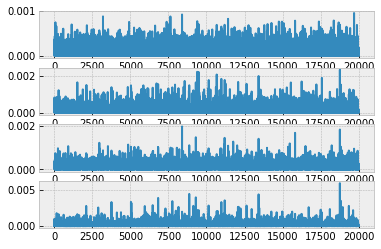

In [9]:
fig, plts = plt.subplots(sim_data["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data["PVDs"][:, i])

In [10]:
sim_params_point_pv = sim_params.copy()
sim_params_point_pv["PV_shape"] = None
sim_data_point_pv = genData2.gen_counts(**sim_params_point_pv)

/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PV = tensor(PV_mean).expand([n_genes,])
/home/akotlar/tada/project/mvl2/genData2.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


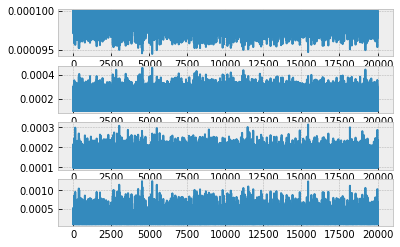

In [11]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data_point_pv["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data_point_pv["PVDs"][:, i])

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


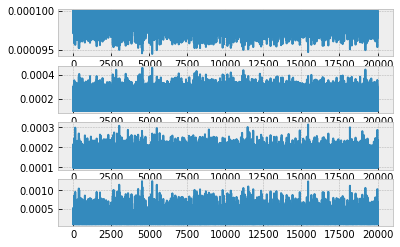

In [12]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data_point_pv["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data_point_pv["PVDs"][:, i])

In [14]:
random_key, _random_key = random.split(random_key)

run_params = {
    "data": sim_data_point_pv["alt_counts"].numpy(),
    "n_cases": sim_params_point_pv["n_cases"].numpy(),
    "n_ctrls": sim_params_point_pv["n_ctrls"].numpy(),
    "max_tree_depth": 8,
    "num_warmup": 2000,
    "num_samples": 4000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model_with_gamma_prior_alpha8,
    "jit_model_args": False,
    "extra_fields": ("potential_energy", "accept_prob", "mean_accept_prob"),
}

mcmc_raymond_sim = run_until_enough(random_key=_random_key, run_params=run_params)

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.13      0.02      0.13      0.09      0.17   1270.69      1.00
                   beta[1]      0.80      0.03      0.81      0.76      0.86   1500.43      1.00
                   beta[2]      0.43      0.12      0.42      0.23      0.62   1012.35      1.00
dirichlet_concentration[0]      3.92      0.92      3.85      2.43      5.43   3823.64      1.00
dirichlet_concentration[1]      2.04      0.70      1.97      0.94      3.21   3657.86      1.00
dirichlet_concentration[2]      1.95      0.66      1.89      0.89      2.98   3805.65      1.00
dirichlet_concentration[3]      1.08      0.44      1.03      0.37      1.76   4107.22      1.00
                probs[0,0]      0.43      0.01      0.43      0.40      0.45   1756.07      1.00
                probs[0,1]      0.36      0.01      0.36      0.34      0.37   1870.61      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.70      0.03      0.71      0.66      0.75    972.52      1.00
                   beta[1]      0.24      0.07      0.24      0.14      0.36    864.60      1.00
                   beta[2]      0.49      0.10      0.49      0.33      0.66   1444.94      1.00
dirichlet_concentration[0]      3.95      0.92      3.88      2.56      5.48   3770.77      1.00
dirichlet_concentration[1]      2.05      0.74      1.98      0.86      3.19   3868.04      1.00
dirichlet_concentration[2]      1.93      0.66      1.87      0.86      2.96   4142.95      1.00
dirichlet_concentration[3]      1.08      0.44      1.02      0.35      1.74   4454.69      1.00
                probs[0,0]      0.60      0.00      0.60      0.59      0.60   1549.46      1.00
                probs[0,1]      0.17      0.00      0.17      0.17      0.18   1781.18      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.71      0.03      0.72      0.67      0.75   1252.99      1.00
                   beta[1]      0.40      0.09      0.40      0.24      0.54   1281.74      1.00
                   beta[2]      0.37      0.09      0.37      0.23      0.51   1589.00      1.00
dirichlet_concentration[0]      3.89      0.91      3.83      2.44      5.37   3564.41      1.00
dirichlet_concentration[1]      2.02      0.69      1.95      0.87      3.08   4241.14      1.00
dirichlet_concentration[2]      1.91      0.66      1.86      0.76      2.84   3746.80      1.00
dirichlet_concentration[3]      1.07      0.45      1.01      0.37      1.78   4470.55      1.00
                probs[0,0]      0.60      0.00      0.60      0.59      0.60   1763.86      1.00
                probs[0,1]      0.17      0.00      0.17      0.17      0.18   2423.72      1.00
                probs[0,2]   

sample: 100%|██████████| 6000/6000 [01:11<00:00, 83.84it/s, 31 steps of size 1.22e-01. acc. prob=0.92] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.71      0.03      0.71      0.66      0.75   1036.99      1.00
                   beta[1]      0.24      0.07      0.23      0.14      0.35   1103.46      1.00
                   beta[2]      0.49      0.10      0.49      0.32      0.66   1409.56      1.00
dirichlet_concentration[0]      3.92      0.96      3.85      2.35      5.43   3655.12      1.00
dirichlet_concentration[1]      2.03      0.71      1.97      0.89      3.13   2794.51      1.00
dirichlet_concentration[2]      1.91      0.67      1.84      0.79      2.94   2985.65      1.00
dirichlet_concentration[3]      1.07      0.44      1.02      0.37      1.77   3665.81      1.00
                probs[0,0]      0.60      0.00      0.60      0.59      0.60   1490.89      1.00
                probs[0,1]      0.17      0.00      0.17      0.17      0.18   1933.14      1.00
                probs[0,2]   

In [28]:
weights, probs, betas, dirichlet_concentrations = ordered_statistics(mcmc_raymond_sim)

order [1 0 3 2]
order [0 3 2 1]
order [0 1 3 2]
order [0 3 2 1]


In [29]:
print('weights mean', weights.mean(1).mean(0))
print('weights std', weights.std(1).mean(0))

weights mean [0.70634615 0.11679433 0.10615352 0.07100626]
weights std [0.03030602 0.02723974 0.02582867 0.02617615]


In [ ]:
sim_params_point_pv["n_cases"]

tensor([15000., 15000.,  4000.])

In [34]:
run_params_2 = run_params.copy()
run_params_2['max_K'] = 4
mcmc1, inferred_params1 = run(_random_key, sim_data=sim_data_point_pv, run_params=run_params_2)

sample: 100%|██████████| 1200/1200 [00:15<00:00, 76.11it/s, 31 steps of size 1.07e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.69      0.04      0.69      0.63      0.75    262.86      1.00
   beta[1]      0.39      0.07      0.39      0.26      0.50    381.59      1.00
   beta[2]      0.50      0.13      0.50      0.28      0.69    285.22      1.00
probs[0,0]      0.60      0.00      0.60      0.59      0.61    338.25      1.00
probs[0,1]      0.18      0.00      0.18      0.17      0.18    488.35      1.00
probs[0,2]      0.18      0.00      0.18      0.17      0.19    318.71      1.00
probs[0,3]      0.05      0.00      0.05      0.04      0.05    310.25      1.00
probs[1,0]      0.42      0.01      0.42      0.40      0.44    561.47      1.00
probs[1,1]      0.37      0.01      0.37      0.35      0.39    418.45      1.00
probs[1,2]      0.12      0.01      0.12      0.11      0.14    414.08      1.00
probs[1,3]      0.09      0.01      0.09      0.08      0.10    492.70      1.00
probs[2,0]      0.33      0

In [36]:
random_key, _random_key = random.split(random_key)

mcmc1_b, inferred_params1_b = run(_random_key, sim_data=sim_data_point_pv, run_params=run_params)

sample: 100%|██████████| 1200/1200 [00:54<00:00, 22.09it/s, 63 steps of size 7.32e-02. acc. prob=0.78] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.69      0.04      0.70      0.63      0.75    252.59      1.01
    beta[1]      0.40      0.07      0.40      0.27      0.51    336.43      1.00
    beta[2]      0.51      0.12      0.52      0.31      0.70    225.02      1.00
    beta[3]      1.00      0.02      1.00      0.99      1.00    105.20      1.01
    beta[4]      0.94      0.15      1.00      0.80      1.00    901.11      1.00
    beta[5]      0.94      0.17      1.00      0.81      1.00    829.48      1.00
    beta[6]      0.94      0.16      1.00      0.81      1.00    919.64      1.00
    beta[7]      0.94      0.15      1.00      0.80      1.00   1067.59      1.00
    beta[8]      0.94      0.17      1.00      0.77      1.00    624.86      1.00
    beta[9]      0.94      0.16      1.00      0.83      1.00    889.72      1.00
   beta[10]      0.93      0.17      1.00      0.80      1.00    960.93      1.00
 probs[0,0]    

In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv('sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.2_h2_2_0.2_rho_0/results.csv')

#df = pd.read_csv('/home/akotlar/tada/project/sim/test_dave3.csv')
pds = np.array([0.022515,0.02302,0.001295])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False,
    "extra_fields": ("potential_energy", "accept_prob", "mean_accept_prob"),
}

In [18]:
stat_data_dave

array([[29,  2,  1,  0],
       [30,  1,  0,  0],
       [47,  3,  1,  0],
       ...,
       [30,  0,  1,  0],
       [34,  1,  1,  0],
       [46,  1,  1,  0]])

In [22]:
# with max chains 10 and x64
numpyro.enable_x64(True)
run_params_dave_d10 = run_params_dave.copy()
run_params_dave_d10['max_tree_depth'] = 10
random_key, _random_key = random.split(random_key)

mcmc_dave_d1064, inferred_params_dave = run(_random_key, run_params=run_params_dave_d10)
numpyro.enable_x64(False)


sample: 100%|██████████| 1200/1200 [09:55<00:00,  2.01it/s, 1023 steps of size 1.92e-03. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.75      0.02      0.75      0.72      0.78     18.86      1.10
   beta[1]      0.22      0.06      0.20      0.12      0.31      5.98      1.32
   beta[2]      0.58      0.08      0.58      0.45      0.71     21.23      1.08
probs[0,0]      0.95      0.00      0.95      0.95      0.96     50.10      1.05
probs[0,1]      0.02      0.00      0.02      0.02      0.02    109.53      1.00
probs[0,2]      0.02      0.00      0.02      0.02      0.02     29.79      1.04
probs[0,3]      0.00      0.00      0.00      0.00      0.00    173.85      1.02
probs[1,0]      0.92      0.01      0.92      0.91      0.93     54.18      1.01
probs[1,1]      0.01      0.00      0.01      0.01      0.02      5.58      1.32
probs[1,2]      0.07      0.01      0.07      0.06      0.08     20.75      1.09
probs[1,3]      0.00      0.00      0.00      0.00      0.00     11.18      1.16
probs[2,0]      0.91      0

In [20]:
# with max chains 10
run_params_dave_d10 = run_params_dave.copy()
run_params_dave_d10['max_tree_depth'] = 10
random_key, _random_key = random.split(random_key)

mcmc_dave_d10, inferred_params_dave = run(_random_key,sim_data={}, run_params=run_params_dave_d10)

sample: 100%|██████████| 1200/1200 [02:43<00:00,  7.33it/s, 255 steps of size 6.21e-03. acc. prob=0.77]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.03      0.01      0.02      0.01      0.05     40.14      1.00
   beta[1]      0.10      0.01      0.10      0.08      0.12    190.23      1.00
   beta[2]      0.13      0.02      0.13      0.10      0.16    185.20      1.04
probs[0,0]      0.93      0.01      0.93      0.92      0.94    218.24      1.01
probs[0,1]      0.00      0.00      0.00      0.00      0.01     50.78      1.00
probs[0,2]      0.07      0.01      0.07      0.06      0.08    125.69      1.01
probs[0,3]      0.00      0.00      0.00      0.00      0.00    126.34      1.01
probs[1,0]      0.88      0.00      0.88      0.88      0.89    123.19      1.00
probs[1,1]      0.04      0.00      0.04      0.04      0.05    122.72      1.01
probs[1,2]      0.07      0.00      0.07      0.06      0.07    205.46      1.01
probs[1,3]      0.01      0.00      0.01      0.01      0.01    123.95      1.00
probs[2,0]      0.90      0

In [19]:
# with better initial prevalence; half the divergences, much larger n_eff
random_key, _random_key = random.split(random_key)

mcmc_dave, inferred_params_dave = run(_random_key,sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [02:41<00:00,  7.42it/s, 511 steps of size 1.15e-02. acc. prob=0.86]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.10      0.01      0.10      0.08      0.12    343.30      1.00
   beta[1]      0.85      0.02      0.86      0.82      0.88    237.50      1.00
   beta[2]      0.83      0.06      0.84      0.74      0.91    168.85      1.01
probs[0,0]      0.88      0.00      0.88      0.88      0.89    392.00      1.00
probs[0,1]      0.04      0.00      0.04      0.04      0.05    270.67      1.01
probs[0,2]      0.07      0.00      0.07      0.06      0.07    465.71      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01    307.13      1.00
probs[1,0]      0.95      0.00      0.95      0.95      0.96    560.67      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02    345.96      1.00
probs[1,2]      0.02      0.00      0.02      0.02      0.02    657.44      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.00    495.13      1.00
probs[2,0]      0.90      0

In [9]:
# just a re-run
# with better initial prevalence; half the divergences, much larger n_eff
random_key, _random_key = random.split(random_key)

mcmc_dave, inferred_params_dave = run(_random_key, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [02:23<00:00,  8.34it/s, 255 steps of size 6.21e-03. acc. prob=0.77]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.03      0.01      0.02      0.01      0.05     40.14      1.00
   beta[1]      0.10      0.01      0.10      0.08      0.12    190.23      1.00
   beta[2]      0.13      0.02      0.13      0.10      0.16    185.20      1.04
probs[0,0]      0.93      0.01      0.93      0.92      0.94    218.24      1.01
probs[0,1]      0.00      0.00      0.00      0.00      0.01     50.78      1.00
probs[0,2]      0.07      0.01      0.07      0.06      0.08    125.69      1.01
probs[0,3]      0.00      0.00      0.00      0.00      0.00    126.34      1.01
probs[1,0]      0.88      0.00      0.88      0.88      0.89    123.19      1.00
probs[1,1]      0.04      0.00      0.04      0.04      0.05    122.72      1.01
probs[1,2]      0.07      0.00      0.07      0.06      0.07    205.46      1.01
probs[1,3]      0.01      0.00      0.01      0.01      0.01    123.95      1.00
probs[2,0]      0.90      0

In [10]:
# re-run again, to see effect of random variability on performance
random_key, _random_key = random.split(random_key)

mcmc_dave, inferred_params_dave = run(_random_key, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [04:28<00:00,  4.46it/s, 1023 steps of size 4.40e-03. acc. prob=0.90]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.11      0.02      0.11      0.09      0.14    362.04      1.00
   beta[1]      0.04      0.02      0.04      0.02      0.07     22.22      1.00
   beta[2]      0.89      0.02      0.89      0.87      0.92     74.45      1.00
probs[0,0]      0.90      0.00      0.90      0.90      0.91    181.42      1.00
probs[0,1]      0.07      0.00      0.07      0.06      0.07    145.65      1.00
probs[0,2]      0.03      0.00      0.03      0.02      0.03    855.39      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.01    673.66      1.00
probs[1,0]      0.92      0.01      0.92      0.91      0.93     86.39      1.01
probs[1,1]      0.01      0.00      0.01      0.00      0.01     21.69      1.01
probs[1,2]      0.07      0.01      0.07      0.06      0.08    216.17      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.00     16.61      1.01
probs[2,0]      0.95      0

In [15]:
# With warmup pruning, seems to hurt performance, slightly, or maybe nto affect ti
random_key, _random_key = random.split(random_key)

run_params_dave_pruned = run_params_dave.copy()
run_params_dave_pruned['thinning'] = 2

mcmc_dave_pruned, inferred_params_dave_pruned = run(_random_key, run_params=run_params_dave_pruned)

sample: 100%|██████████| 1200/1200 [03:07<00:00,  6.40it/s, 255 steps of size 6.63e-03. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.10      0.01      0.10      0.08      0.12    195.16      1.00
   beta[1]      0.12      0.02      0.12      0.10      0.15    276.86      1.01
   beta[2]      0.04      0.02      0.03      0.01      0.07     85.21      1.00
probs[0,0]      0.88      0.00      0.88      0.88      0.89     91.60      1.00
probs[0,1]      0.04      0.00      0.04      0.04      0.05     78.84      1.00
probs[0,2]      0.07      0.00      0.07      0.06      0.07    300.57      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01    159.09      1.00
probs[1,0]      0.90      0.00      0.90      0.90      0.91    262.01      1.02
probs[1,1]      0.07      0.00      0.07      0.06      0.07    353.35      1.02
probs[1,2]      0.03      0.00      0.02      0.02      0.03    274.03      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    172.04      1.00
probs[2,0]      0.93      0

In [16]:
# With warmup pruning and 2x the warmup steps
# to confirm that thinning really hurts

random_key, _random_key = random.split(random_key)

run_params_dave_pruned_more = run_params_dave.copy()
run_params_dave_pruned_more['thinning'] = 2
run_params_dave_pruned_more['num_warmup'] = 2 * run_params_dave['num_warmup']

mcmc_dave_pruned_more, inferred_params_dave_pruned_more = run(_random_key, run_params=run_params_dave_pruned_more)

sample: 100%|██████████| 1400/1400 [00:57<00:00, 24.24it/s, 3 steps of size 2.39e-02. acc. prob=0.00]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.76      0.00      0.76      0.76      0.76      0.50       nan
   beta[1]      0.23      0.00      0.23      0.23      0.23      0.50      1.00
   beta[2]      0.35      0.00      0.35      0.35      0.35      0.50      1.00
probs[0,0]      0.95      0.00      0.95      0.95      0.95      0.50      1.00
probs[0,1]      0.02      0.00      0.02      0.02      0.02      0.50      1.00
probs[0,2]      0.02      0.00      0.02      0.02      0.02      0.50      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00      0.50      1.00
probs[1,0]      0.93      0.00      0.93      0.93      0.93      0.50      1.00
probs[1,1]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
probs[1,2]      0.06      0.00      0.06      0.06      0.06      0.50      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.00      0.50      1.00
probs[2,0]      0.88      0

In [17]:
# rerun to confirm that thinning really hurts
# With warmup pruning and 2x the warmup steps

random_key, _random_key = random.split(random_key)

run_params_dave_pruned_more = run_params_dave.copy()
run_params_dave_pruned_more['thinning'] = 2
run_params_dave_pruned_more['num_warmup'] = 2 * run_params_dave['num_warmup']

mcmc_dave_pruned_more, inferred_params_dave_pruned_more = run(_random_key, run_params=run_params_dave_pruned_more)

sample: 100%|██████████| 1400/1400 [00:32<00:00, 42.43it/s, 7 steps of size 4.67e-02. acc. prob=0.46]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.13      0.01      0.13      0.12      0.15      5.23      1.47
   beta[1]      0.89      0.01      0.89      0.87      0.90      5.46      1.50
   beta[2]      0.94      0.07      0.99      0.84      1.00      2.81      2.34
probs[0,0]      0.90      0.00      0.90      0.89      0.90      3.46      1.85
probs[0,1]      0.07      0.00      0.07      0.06      0.07      6.40      1.39
probs[0,2]      0.03      0.00      0.03      0.03      0.03      4.49      1.56
probs[0,3]      0.01      0.00      0.01      0.00      0.01      4.61      1.68
probs[1,0]      0.95      0.00      0.95      0.95      0.96      3.77      1.79
probs[1,1]      0.02      0.00      0.02      0.02      0.02      3.18      2.02
probs[1,2]      0.02      0.00      0.02      0.02      0.02     66.26      1.04
probs[1,3]      0.00      0.00      0.00      0.00      0.00      9.13      1.26
probs[2,0]      0.89      0

In [18]:
# Without warmup pruning and 2x the warmup steps
random_key, _random_key = random.split(random_key)

run_params_dave_pruned_more = run_params_dave.copy()
run_params_dave_pruned_more['thinning'] = 1
run_params_dave_pruned_more['num_warmup'] = 2 * run_params_dave['num_warmup']

mcmc_dave_pruned_more, inferred_params_dave_pruned_more = run(_random_key, run_params=run_params_dave_pruned_more)

sample: 100%|██████████| 1400/1400 [05:59<00:00,  3.89it/s, 383 steps of size 7.26e-03. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.11      0.08      0.10      0.08      0.12     68.67      1.02
   beta[1]      0.86      0.03      0.85      0.82      0.88     52.60      1.03
   beta[2]      0.04      0.13      0.02      0.00      0.05     50.69      1.01
probs[0,0]      0.89      0.01      0.89      0.89      0.90    101.58      1.01
probs[0,1]      0.03      0.00      0.03      0.03      0.04     81.61      1.02
probs[0,2]      0.07      0.01      0.07      0.07      0.08     50.02      1.03
probs[0,3]      0.01      0.00      0.01      0.00      0.01    221.07      1.00
probs[1,0]      0.95      0.00      0.95      0.95      0.96    126.84      1.01
probs[1,1]      0.02      0.00      0.02      0.02      0.02    126.86      1.01
probs[1,2]      0.02      0.00      0.02      0.02      0.02    136.95      1.01
probs[1,3]      0.00      0.00      0.00      0.00      0.00    146.81      1.00
probs[2,0]      0.99      0

In [19]:
# Without warmup pruning and 2x the warmup steps, rerun
random_key, _random_key = random.split(random_key)

run_params_dave_pruned_more = run_params_dave.copy()
run_params_dave_pruned_more['thinning'] = 1
run_params_dave_pruned_more['num_warmup'] = 2 * run_params_dave['num_warmup']

mcmc_dave_pruned_more, inferred_params_dave_pruned_more = run(_random_key, run_params=run_params_dave_pruned_more)

sample: 100%|██████████| 1400/1400 [04:03<00:00,  5.74it/s, 511 steps of size 6.15e-03. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.10      0.01      0.10      0.08      0.12    256.65      1.00
   beta[1]      0.13      0.02      0.13      0.10      0.15    264.43      1.00
   beta[2]      0.97      0.01      0.97      0.95      0.99    173.85      1.00
probs[0,0]      0.88      0.00      0.88      0.88      0.89    309.92      1.00
probs[0,1]      0.04      0.00      0.04      0.04      0.05    233.89      1.00
probs[0,2]      0.07      0.00      0.07      0.06      0.07    351.70      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01    356.83      1.00
probs[1,0]      0.90      0.00      0.90      0.90      0.91    269.01      1.00
probs[1,1]      0.07      0.00      0.07      0.06      0.07    272.00      1.00
probs[1,2]      0.03      0.00      0.03      0.02      0.03    300.24      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    371.96      1.00
probs[2,0]      0.95      0

In [20]:
# Without warmup pruning and 2x the warmup steps, and more smaples
random_key, _random_key = random.split(random_key)

run_params_dave_pruned_more = run_params_dave.copy()
run_params_dave_pruned_more['thinning'] = 1
run_params_dave_pruned_more['num_warmup'] = 2 * run_params_dave['num_warmup']

run_params_dave_pruned_more['num_samples'] = 2 * run_params_dave['num_samples']

mcmc_dave_pruned_more, inferred_params_dave_pruned_more = run(_random_key, run_params=run_params_dave_pruned_more)

sample: 100%|██████████| 2400/2400 [01:59<00:00, 20.10it/s, 127 steps of size 6.28e-02. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.03      0.02      0.03      0.01      0.06     90.66      1.00
   beta[1]      0.12      0.02      0.12      0.09      0.14    792.86      1.00
   beta[2]      0.89      0.01      0.89      0.87      0.91    285.67      1.00
probs[0,0]      0.93      0.01      0.93      0.91      0.94    212.53      1.00
probs[0,1]      0.01      0.01      0.01      0.00      0.01     74.78      1.00
probs[0,2]      0.07      0.01      0.07      0.06      0.08    654.74      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00    119.36      1.01
probs[1,0]      0.90      0.00      0.90      0.90      0.91    451.25      1.00
probs[1,1]      0.07      0.00      0.07      0.06      0.07    756.52      1.00
probs[1,2]      0.03      0.00      0.03      0.02      0.03    697.69      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    614.24      1.00
probs[2,0]      0.95      0

In [21]:
# Without warmup pruning and 2x the warmup steps, and more smaples, rerun
random_key, _random_key = random.split(random_key)

run_params_dave_pruned_more = run_params_dave.copy()
run_params_dave_pruned_more['thinning'] = 1
run_params_dave_pruned_more['num_warmup'] = 2 * run_params_dave['num_warmup']

run_params_dave_pruned_more['num_samples'] = 2 * run_params_dave['num_samples']

mcmc_dave_pruned_more, inferred_params_dave_pruned_more = run(_random_key, run_params=run_params_dave_pruned_more)

sample: 100%|██████████| 2400/2400 [12:32<00:00,  3.19it/s, 1023 steps of size 3.30e-03. acc. prob=0.89]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.03      0.01      0.02      0.01      0.05      6.47      1.30
   beta[1]      0.10      0.01      0.10      0.08      0.12     47.18      1.05
   beta[2]      0.88      0.02      0.88      0.85      0.90   1675.42      1.00
probs[0,0]      0.93      0.01      0.93      0.92      0.94     19.07      1.11
probs[0,1]      0.00      0.00      0.00      0.00      0.01      4.81      1.41
probs[0,2]      0.07      0.01      0.07      0.06      0.08    413.97      1.02
probs[0,3]      0.00      0.00      0.00      0.00      0.00      7.83      1.36
probs[1,0]      0.88      0.00      0.88      0.88      0.89     21.39      1.09
probs[1,1]      0.04      0.00      0.04      0.04      0.05      8.79      1.21
probs[1,2]      0.07      0.00      0.07      0.06      0.07    111.52      1.03
probs[1,3]      0.01      0.00      0.01      0.01      0.01     14.37      1.12
probs[2,0]      0.95      0

In [22]:
# Without warmup pruning and 4x the warmup steps, and 4x smaples, rerun
random_key, _random_key = random.split(random_key)

run_params_dave_pruned_more = run_params_dave.copy()
run_params_dave_pruned_more['thinning'] = 1
run_params_dave_pruned_more['num_warmup'] = 4 * run_params_dave['num_warmup']

run_params_dave_pruned_more['num_samples'] = 4 * run_params_dave['num_samples']

mcmc_dave_4x_samples, inferred_params_dave_4x_samples = run(_random_key, run_params=run_params_dave_pruned_more)

sample: 100%|██████████| 4800/4800 [06:11<00:00, 12.92it/s, 255 steps of size 1.39e-02. acc. prob=0.78] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.11      0.01      0.11      0.09      0.13    579.97      1.00
   beta[1]      0.03      0.01      0.02      0.01      0.04    126.52      1.00
   beta[2]      0.12      0.01      0.12      0.10      0.14    477.34      1.00
probs[0,0]      0.90      0.00      0.90      0.90      0.91    445.92      1.00
probs[0,1]      0.07      0.00      0.07      0.06      0.07    478.94      1.00
probs[0,2]      0.03      0.00      0.03      0.02      0.03    600.23      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.01    579.15      1.00
probs[1,0]      0.93      0.01      0.93      0.92      0.94    351.24      1.00
probs[1,1]      0.00      0.00      0.00      0.00      0.01    102.53      1.00
probs[1,2]      0.07      0.01      0.07      0.06      0.08   1181.79      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.00    426.57      1.00
probs[2,0]      0.88      0

In [23]:
# Without warmup pruning and 4 the warmup steps, and 4 smaples, rerun
random_key, _random_key = random.split(random_key)

run_params_dave_pruned_more = run_params_dave.copy()
run_params_dave_pruned_more['thinning'] = 1
run_params_dave_pruned_more['num_warmup'] = 4 * run_params_dave['num_warmup']

run_params_dave_pruned_more['num_samples'] = 4 * run_params_dave['num_samples']

mcmc_dave_4x_samples2, inferred_params_dave_4x_samples2 = run(_random_key, run_params=run_params_dave_pruned_more)

sample: 100%|██████████| 4800/4800 [03:29<00:00, 22.86it/s, 31 steps of size 2.75e-02. acc. prob=0.74] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.77      0.01      0.77      0.74      0.79    694.97      1.01
   beta[1]      0.47      0.05      0.47      0.39      0.55    216.12      1.01
   beta[2]      0.81      0.07      0.83      0.68      0.89     36.22      1.03
probs[0,0]      0.95      0.00      0.95      0.95      0.96    784.66      1.01
probs[0,1]      0.02      0.00      0.02      0.02      0.02   1192.66      1.00
probs[0,2]      0.02      0.00      0.02      0.02      0.02    184.30      1.01
probs[0,3]      0.00      0.00      0.00      0.00      0.00     57.16      1.01
probs[1,0]      0.90      0.00      0.90      0.90      0.91   1018.10      1.00
probs[1,1]      0.07      0.00      0.07      0.06      0.07    617.72      1.01
probs[1,2]      0.03      0.00      0.02      0.02      0.03    305.77      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    319.99      1.00
probs[2,0]      0.88      0

In [24]:
# Without warmup pruning and 8x the warmup steps, and 2 samples
random_key, _random_key = random.split(random_key)

run_params_dave_pruned_more = run_params_dave.copy()
run_params_dave_pruned_more['thinning'] = 1
run_params_dave_pruned_more['num_warmup'] = 8 * run_params_dave['num_warmup']

run_params_dave_pruned_more['num_samples'] = 2 * run_params_dave['num_samples']

mcmc_dave_8x_samples, inferred_params_dave_8x_samples = run(_random_key, run_params=run_params_dave_pruned_more)

sample: 100%|██████████| 3600/3600 [03:54<00:00, 15.33it/s, 511 steps of size 1.04e-02. acc. prob=0.77] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.03      0.01      0.02      0.01      0.04     78.22      1.00
   beta[1]      0.78      0.01      0.79      0.76      0.81    380.61      1.01
   beta[2]      0.53      0.05      0.53      0.44      0.62    225.78      1.00
probs[0,0]      0.93      0.01      0.93      0.92      0.94    244.94      1.00
probs[0,1]      0.00      0.00      0.00      0.00      0.01     63.48      1.01
probs[0,2]      0.07      0.01      0.07      0.06      0.08    447.73      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00    183.18      1.01
probs[1,0]      0.95      0.00      0.95      0.95      0.96    298.23      1.01
probs[1,1]      0.02      0.00      0.02      0.02      0.02    289.83      1.01
probs[1,2]      0.02      0.00      0.02      0.02      0.02    307.92      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.00    248.35      1.01
probs[2,0]      0.90      0

In [25]:
# Without warmup pruning and 8x the warmup steps, and 2 samples, rerun
random_key, _random_key = random.split(random_key)

run_params_dave_pruned_more = run_params_dave.copy()
run_params_dave_pruned_more['thinning'] = 1
run_params_dave_pruned_more['num_warmup'] = 8 * run_params_dave['num_warmup']

run_params_dave_pruned_more['num_samples'] = 2 * run_params_dave['num_samples']

mcmc_dave_8x_samples, inferred_params_dave_8x_samples = run(_random_key, run_params=run_params_dave_pruned_more)

sample: 100%|██████████| 3600/3600 [01:54<00:00, 31.48it/s, 107 steps of size 6.01e-02. acc. prob=0.74]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.10      0.01      0.10      0.09      0.12    311.79      1.00
   beta[1]      0.86      0.01      0.86      0.83      0.88    348.11      1.00
   beta[2]      0.85      0.03      0.85      0.80      0.90    282.38      1.01
probs[0,0]      0.88      0.00      0.88      0.88      0.89    683.36      1.00
probs[0,1]      0.04      0.00      0.04      0.04      0.04    494.57      1.00
probs[0,2]      0.07      0.00      0.07      0.06      0.07    334.75      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01    719.07      1.00
probs[1,0]      0.95      0.00      0.95      0.95      0.96    483.71      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02    343.57      1.00
probs[1,2]      0.02      0.00      0.02      0.02      0.02    748.62      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.00    370.41      1.00
probs[2,0]      0.90      0

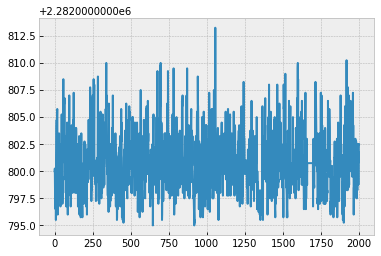

In [50]:
plt.plot(
mcmc_dave_8x_samples.get_extra_fields(group_by_chain=True)['potential_energy'][0])


In [26]:
# Without warmup pruning and 8x the warmup steps, and 8x samples
random_key, _random_key = random.split(random_key)

run_params_dave_pruned_more = run_params_dave.copy()
run_params_dave_pruned_more['thinning'] = 1
run_params_dave_pruned_more['num_warmup'] = 8 * run_params_dave['num_warmup']

run_params_dave_pruned_more['num_samples'] = 8 * run_params_dave['num_samples']

mcmc_dave_8x_warmup_8x_samples, inferred_params_dave_8x_warmup_8x_samples = run(_random_key, run_params=run_params_dave_pruned_more)

sample: 100%|██████████| 9600/9600 [43:27<00:00,  3.68it/s, 1023 steps of size 4.56e-03. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.03      0.02      0.03      0.01      0.05    414.98      1.00
   beta[1]      0.79      0.01      0.79      0.76      0.81   2200.14      1.00
   beta[2]      0.48      0.06      0.48      0.39      0.58   1594.27      1.00
probs[0,0]      0.93      0.01      0.93      0.92      0.94    844.90      1.00
probs[0,1]      0.00      0.01      0.00      0.00      0.01    319.32      1.00
probs[0,2]      0.07      0.01      0.07      0.06      0.08   2126.31      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00    880.84      1.00
probs[1,0]      0.95      0.00      0.95      0.95      0.96   2475.72      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02   3294.11      1.00
probs[1,2]      0.02      0.00      0.02      0.02      0.02   1873.76      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.00   3930.20      1.00
probs[2,0]      0.88      0

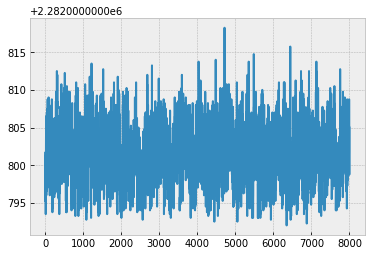

In [49]:
plt.plot(
mcmc_dave_8x_warmup_8x_samples.get_extra_fields(group_by_chain=True)['potential_energy'][0])


In [243]:
# 2000 warmup steps 4000 samples, with gamma prior
# works ok
random_key, _random_key = random.split(random_key)

run_params_dave_2k_4k_gamma = run_params_dave.copy()
run_params_dave_2k_4k_gamma['num_warmup'] = 2000
run_params_dave_2k_4k_gamma['num_samples'] = 4000
run_params_dave_2k_4k_gamma['model_to_run'] = model_with_gamma_prior_alpha

mcmc_dave_2k_warmup_4k_samples_gamma, inferred_params_dave_2k_warmup_4k_samples_gamma = run_until_enough(_random_key, run_params=run_params_dave_2k_4k_gamma)

  0%|          | 0/6000 [00:00<?, ?it/s]


                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.02      0.04      0.01      0.07    288.44      1.00
                     beta[1]      0.12      0.02      0.12      0.09      0.15    835.42      1.00
                     beta[2]      0.89      0.02      0.89      0.87      0.92    574.03      1.00
dirichlet_concentration[0,0]      1.53      1.23      1.21      0.04      3.20   2814.71      1.00
dirichlet_concentration[0,1]      0.18      0.20      0.11      0.00      0.43   1280.45      1.00
dirichlet_concentration[0,2]      0.31      0.31      0.22      0.00      0.71   2702.39      1.00
dirichlet_concentration[0,3]      0.13      0.13      0.08      0.00      0.29   1848.02      1.00
dirichlet_concentration[1,0]      1.62      1.22      1.32      0.06      3.19   2678.77      1.00
dirichlet_concentration[1,1]      0.32      0.32      0.23      0.00      0.73   3052.80      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]


                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.11      0.02      0.11      0.09      0.14   1374.92      1.00
                     beta[1]      0.05      0.02      0.04      0.01      0.08    221.34      1.00
                     beta[2]      0.89      0.02      0.89      0.87      0.92    505.54      1.00
dirichlet_concentration[0,0]      1.59      1.25      1.27      0.05      3.31   5700.19      1.00
dirichlet_concentration[0,1]      0.33      0.33      0.23      0.00      0.74   5540.07      1.00
dirichlet_concentration[0,2]      0.26      0.26      0.18      0.00      0.59   5973.43      1.00
dirichlet_concentration[0,3]      0.18      0.18      0.12      0.00      0.40   5587.29      1.00
dirichlet_concentration[1,0]      1.54      1.20      1.26      0.03      3.20   5705.95      1.00
dirichlet_concentration[1,1]      0.17      0.20      0.11      0.00      0.43    543.23      1.00
dirichlet

warmup:   3%|▎         | 183/6000 [00:39<21:03,  4.60it/s, 63 steps of size 4.51e-02. acc. prob=0.77]    


KeyboardInterrupt: 

In [256]:
# 2000 warmup steps 4000 samples, with gamma prior
# works ok
random_key, _random_key = random.split(random_key)

run_params_dave_2k_4k_gamma3 = run_params_dave.copy()
run_params_dave_2k_4k_gamma3['num_warmup'] = 2000
run_params_dave_2k_4k_gamma3['num_samples'] = 4000
run_params_dave_2k_4k_gamma3['model_to_run'] = model_with_gamma_prior_alpha3

mcmc_dave_2k_warmup_4k_samples_gamma3 = run_until_enough(_random_key, run_params=run_params_dave_2k_4k_gamma3)

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.09      0.01      0.09      0.07      0.12   1349.53      1.00
                   beta[1]      0.83      0.03      0.84      0.79      0.87   1290.54      1.00
                   beta[2]      0.73      0.07      0.73      0.61      0.84   1207.48      1.00
dirichlet_concentration[0]     15.47      7.16     14.37      4.34     26.29   2558.63      1.00
dirichlet_concentration[1]      0.84      0.42      0.77      0.18      1.44   2774.51      1.00
dirichlet_concentration[2]      1.05      0.51      0.98      0.30      1.86   2929.27      1.00
dirichlet_concentration[3]      0.31      0.16      0.29      0.07      0.55   3003.57      1.00
                probs[0,0]      0.88      0.00      0.88      0.87      0.89   1351.59      1.00
                probs[0,1]      0.05      0.00      0.05      0.04      0.05   1095.82      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.75      0.02      0.76      0.72      0.78   1263.19      1.00
                   beta[1]      0.20      0.06      0.20      0.11      0.30   1044.61      1.00
                   beta[2]      0.45      0.07      0.45      0.33      0.56    893.04      1.00
dirichlet_concentration[0]     15.92      7.29     14.83      5.07     27.04   2492.00      1.00
dirichlet_concentration[1]      0.88      0.43      0.81      0.21      1.52   2694.41      1.00
dirichlet_concentration[2]      1.05      0.52      0.96      0.25      1.79   2705.46      1.00
dirichlet_concentration[3]      0.33      0.16      0.30      0.08      0.56   2750.85      1.00
                probs[0,0]      0.95      0.00      0.95      0.95      0.96   1488.05      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   1897.79      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.05      0.02      0.05      0.02      0.08    635.98      1.00
                   beta[1]      0.09      0.01      0.09      0.07      0.12   1249.18      1.00
                   beta[2]      0.13      0.02      0.13      0.10      0.16   1464.33      1.00
dirichlet_concentration[0]     15.82      7.28     14.71      3.94     26.52   3137.98      1.00
dirichlet_concentration[1]      0.88      0.44      0.82      0.24      1.54   2467.56      1.00
dirichlet_concentration[2]      1.05      0.51      0.97      0.28      1.81   3134.29      1.00
dirichlet_concentration[3]      0.32      0.16      0.30      0.07      0.56   3469.74      1.00
                probs[0,0]      0.92      0.01      0.92      0.91      0.93   1605.52      1.00
                probs[0,1]      0.01      0.00      0.01      0.00      0.02    522.98      1.00
                probs[0,2]   

sample: 100%|██████████| 6000/6000 [01:46<00:00, 56.30it/s, 63 steps of size 8.75e-02. acc. prob=0.90]  



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.75      0.02      0.75      0.72      0.78   1688.76      1.00
                   beta[1]      0.46      0.05      0.46      0.37      0.54   2147.51      1.00
                   beta[2]      0.37      0.11      0.36      0.19      0.53   1351.44      1.00
dirichlet_concentration[0]     15.71      7.16     14.60      4.50     26.26   3313.02      1.00
dirichlet_concentration[1]      0.88      0.44      0.81      0.19      1.50   3114.55      1.00
dirichlet_concentration[2]      1.05      0.51      0.97      0.28      1.81   3660.62      1.00
dirichlet_concentration[3]      0.32      0.16      0.29      0.08      0.56   3617.17      1.00
                probs[0,0]      0.95      0.00      0.95      0.95      0.96   2143.57      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   2403.79      1.00
                probs[0,2]   

In [260]:
pd_with_both_exp2.std(0)

0.40607005908771454

In [255]:
# 2000 warmup steps 4000 samples, with gamma prior
# works well, but for some reason converges slower than the rate = 1/k version
random_key, _random_key = random.split(random_key)

run_params_dave_2k_4k_gamma4 = run_params_dave.copy()
run_params_dave_2k_4k_gamma4['num_warmup'] = 2000
run_params_dave_2k_4k_gamma4['num_samples'] = 4000
run_params_dave_2k_4k_gamma4['model_to_run'] = model_with_gamma_prior_alpha4

mcmc_dave_2k_warmup_4k_samples_gamma4 = run_until_enough(_random_key, run_params=run_params_dave_2k_4k_gamma4)

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.76      0.02      0.76      0.73      0.79    993.57      1.00
                   beta[1]      0.39      0.06      0.40      0.30      0.50    689.87      1.00
                   beta[2]      0.75      0.07      0.75      0.64      0.87    592.68      1.00
dirichlet_concentration[0]      3.94      1.96      3.67      0.82      6.70   2739.38      1.00
dirichlet_concentration[1]      0.41      0.21      0.38      0.10      0.71   1780.52      1.00
dirichlet_concentration[2]      0.49      0.24      0.45      0.10      0.83   3734.07      1.00
dirichlet_concentration[3]      0.21      0.11      0.19      0.05      0.37   2482.60      1.00
                probs[0,0]      0.95      0.00      0.95      0.95      0.96   1508.68      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   1457.80      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.76      0.02      0.76      0.73      0.79   1495.39      1.00
                   beta[1]      0.38      0.06      0.39      0.29      0.49   1057.93      1.00
                   beta[2]      0.28      0.07      0.28      0.16      0.39    997.16      1.00
dirichlet_concentration[0]      4.00      1.97      3.68      0.84      6.83   3629.76      1.00
dirichlet_concentration[1]      0.42      0.22      0.39      0.11      0.75   3232.11      1.00
dirichlet_concentration[2]      0.49      0.24      0.45      0.11      0.84   3708.63      1.00
dirichlet_concentration[3]      0.21      0.11      0.20      0.05      0.38   3068.70      1.00
                probs[0,0]      0.95      0.00      0.95      0.95      0.96   2064.77      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   2379.75      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.05      0.02      0.05      0.02      0.08    997.87      1.00
                   beta[1]      0.12      0.02      0.12      0.09      0.15   1546.21      1.00
                   beta[2]      0.90      0.02      0.90      0.87      0.93   1380.90      1.00
dirichlet_concentration[0]      4.00      1.94      3.70      1.21      7.10   3820.06      1.00
dirichlet_concentration[1]      0.43      0.22      0.40      0.11      0.75   4128.37      1.00
dirichlet_concentration[2]      0.49      0.25      0.45      0.12      0.87   3426.73      1.00
dirichlet_concentration[3]      0.22      0.11      0.20      0.05      0.38   3861.16      1.00
                probs[0,0]      0.92      0.01      0.92      0.91      0.93   1574.82      1.00
                probs[0,1]      0.01      0.00      0.01      0.00      0.02    918.98      1.00
                probs[0,2]   

sample: 100%|██████████| 6000/6000 [07:36<00:00, 13.13it/s, 63 steps of size 6.14e-02. acc. prob=0.91]   



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.11      0.02      0.11      0.09      0.14   1547.70      1.00
                   beta[1]      0.10      0.02      0.10      0.08      0.13    972.33      1.00
                   beta[2]      0.95      0.02      0.95      0.92      0.98    581.27      1.00
dirichlet_concentration[0]      3.90      1.94      3.58      0.90      6.71   3114.86      1.00
dirichlet_concentration[1]      0.41      0.21      0.37      0.09      0.71   2476.79      1.00
dirichlet_concentration[2]      0.49      0.24      0.45      0.13      0.84   4627.74      1.00
dirichlet_concentration[3]      0.21      0.11      0.19      0.05      0.37   3623.70      1.00
                probs[0,0]      0.90      0.00      0.90      0.90      0.91   1334.47      1.00
                probs[0,1]      0.07      0.00      0.07      0.06      0.07   1583.78      1.00
                probs[0,2]   

In [266]:
# 2000 warmup steps 4000 samples, with gamma prior
# works well, but for some reason converges slower than the rate = 1/k version
random_key, _random_key = random.split(random_key)

run_params_dave_2k_4k_gamma5 = run_params_dave.copy()
run_params_dave_2k_4k_gamma5['num_warmup'] = 2000
run_params_dave_2k_4k_gamma5['num_samples'] = 4000
run_params_dave_2k_4k_gamma5['model_to_run'] = model_with_gamma_prior_alpha5

mcmc_dave_2k_warmup_4k_samples_gamma5 = run_until_enough(random_key=_random_key, run_params=run_params_dave_2k_4k_gamma5)

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.75      0.02      0.75      0.72      0.78   1218.08      1.00
                   beta[1]      0.46      0.05      0.46      0.38      0.55   1954.84      1.00
                   beta[2]      0.36      0.11      0.35      0.18      0.54    882.78      1.00
dirichlet_concentration[0]     10.02      4.75      9.28      2.31     16.60   2873.17      1.00
dirichlet_concentration[1]      0.67      0.34      0.62      0.17      1.18   2752.96      1.00
dirichlet_concentration[2]      0.79      0.39      0.72      0.19      1.38   3450.56      1.00
dirichlet_concentration[3]      0.28      0.15      0.26      0.06      0.49   3566.45      1.00
                probs[0,0]      0.95      0.00      0.95      0.95      0.96   1514.53      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   1918.29      1.00
                probs[0,2]   

warmup:   1%|▏         | 82/6000 [00:41<50:17,  1.96it/s, 191 steps of size 5.38e-03. acc. prob=0.75]   


KeyboardInterrupt: 

In [278]:
# 2000 warmup steps 4000 samples, with gamma prior that is initialized to mean and standard deviation of prevalence
random_key, _random_key = random.split(random_key)

run_params_dave_2k_4k_gamma6 = run_params_dave.copy()
run_params_dave_2k_4k_gamma6['num_warmup'] = 2000
run_params_dave_2k_4k_gamma6['num_samples'] = 4000
run_params_dave_2k_4k_gamma6['model_to_run'] = model_with_gamma_prior_alpha6

mcmc_dave_2k_warmup_4k_samples_gamma6 = run_until_enough(random_key=_random_key, run_params=run_params_dave_2k_4k_gamma6)

sample:  96%|█████████▋| 5777/6000 [03:47<00:08, 25.42it/s, 15 steps of size 1.39e-01. acc. prob=0.87] 


KeyboardInterrupt: 

In [280]:
# 2000 warmup steps 4000 samples, with gamma prior that is initialized to mean and standard deviation of prevalence
random_key, _random_key = random.split(random_key)

run_params_dave_2k_4k_gamma7 = run_params_dave.copy()
run_params_dave_2k_4k_gamma7['num_warmup'] = 2000
run_params_dave_2k_4k_gamma7['num_samples'] = 4000
run_params_dave_2k_4k_gamma7['model_to_run'] = model_with_gamma_prior_alpha7

mcmc_dave_2k_warmup_4k_samples_gamma7 = run_until_enough(random_key=_random_key, run_params=run_params_dave_2k_4k_gamma7)

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.05      0.02      0.05      0.03      0.08   1128.02      1.00
                   beta[1]      0.12      0.02      0.12      0.09      0.15   1412.40      1.00
                   beta[2]      0.90      0.02      0.90      0.87      0.93   1401.40      1.00
dirichlet_concentration[0]     20.97      0.97     20.94     19.43     22.58   4800.99      1.00
dirichlet_concentration[1]      1.08      0.40      1.03      0.43      1.69   3834.00      1.00
dirichlet_concentration[2]      1.28      0.45      1.24      0.57      2.00   4781.01      1.00
dirichlet_concentration[3]      0.37      0.17      0.34      0.09      0.61   3902.32      1.00
                probs[0,0]      0.92      0.01      0.92      0.91      0.93   1435.05      1.00
                probs[0,1]      0.01      0.00      0.01      0.01      0.02   1070.07      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.05      0.02      0.05      0.03      0.08    864.38      1.00
                   beta[1]      0.12      0.02      0.12      0.09      0.15   1192.47      1.00
                   beta[2]      0.90      0.02      0.90      0.87      0.93    935.45      1.00
dirichlet_concentration[0]     20.95      1.02     20.93     19.28     22.58   4315.23      1.00
dirichlet_concentration[1]      1.07      0.40      1.03      0.45      1.72   4046.47      1.00
dirichlet_concentration[2]      1.28      0.44      1.24      0.58      2.01   4230.02      1.00
dirichlet_concentration[3]      0.37      0.17      0.34      0.10      0.63   3815.50      1.00
                probs[0,0]      0.92      0.01      0.92      0.91      0.93   1750.84      1.00
                probs[0,1]      0.01      0.00      0.01      0.01      0.02    926.74      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.09      0.01      0.09      0.06      0.11   1733.48      1.00
                   beta[1]      0.12      0.02      0.12      0.09      0.15   1866.03      1.00
                   beta[2]      0.94      0.02      0.95      0.92      0.97   1413.92      1.00
dirichlet_concentration[0]     20.93      1.00     20.92     19.24     22.51   4273.55      1.00
dirichlet_concentration[1]      1.04      0.40      1.00      0.39      1.65   3890.55      1.00
dirichlet_concentration[2]      1.27      0.46      1.23      0.51      1.99   3744.05      1.00
dirichlet_concentration[3]      0.35      0.17      0.33      0.09      0.60   2674.50      1.00
                probs[0,0]      0.88      0.00      0.88      0.87      0.89   1667.94      1.00
                probs[0,1]      0.05      0.00      0.05      0.04      0.05   1077.18      1.00
                probs[0,2]   

sample: 100%|██████████| 6000/6000 [06:07<00:00, 16.30it/s, 31 steps of size 1.00e-01. acc. prob=0.90]   



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.76      0.02      0.76      0.73      0.78   1795.92      1.00
                   beta[1]      0.38      0.06      0.38      0.27      0.48   1422.43      1.00
                   beta[2]      0.72      0.07      0.73      0.61      0.84   1114.95      1.00
dirichlet_concentration[0]     20.96      0.98     20.95     19.31     22.55   4828.76      1.00
dirichlet_concentration[1]      1.04      0.40      1.00      0.40      1.64   3939.25      1.00
dirichlet_concentration[2]      1.27      0.45      1.23      0.52      1.97   4121.91      1.00
dirichlet_concentration[3]      0.36      0.17      0.34      0.08      0.61   3938.47      1.00
                probs[0,0]      0.95      0.00      0.95      0.95      0.96   2232.04      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   2476.17      1.00
                probs[0,2]   

In [5]:
# 2000 warmup steps 4000 samples, with gamma prior that is initialized to mean and standard deviation of the per-patient-group stats
random_key, _random_key = random.split(random_key)

run_params_dave_2k_4k_gamma8 = run_params_dave.copy()
run_params_dave_2k_4k_gamma8['num_warmup'] = 2000
run_params_dave_2k_4k_gamma8['num_samples'] = 4000
run_params_dave_2k_4k_gamma8['model_to_run'] = model_with_gamma_prior_alpha8

mcmc_dave_2k_warmup_4k_samples_gamma8 = run_until_enough(random_key=_random_key, run_params=run_params_dave_2k_4k_gamma8)

sample: 100%|██████████| 6000/6000 [01:38<00:00, 60.95it/s, 63 steps of size 9.26e-02. acc. prob=0.91] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.05      0.02      0.05      0.02      0.08    871.63      1.00
                   beta[1]      0.12      0.02      0.12      0.09      0.15   1559.37      1.00
                   beta[2]      0.90      0.02      0.90      0.87      0.93   1317.85      1.00
dirichlet_concentration[0]      6.65      1.05      6.59      5.01      8.44   3778.18      1.00
dirichlet_concentration[1]      0.63      0.27      0.59      0.19      1.01   4147.58      1.00
dirichlet_concentration[2]      0.72      0.29      0.69      0.26      1.17   4186.12      1.00
dirichlet_concentration[3]      0.26      0.13      0.24      0.06      0.45   3502.73      1.00
                probs[0,0]      0.92      0.01      0.92      0.91      0.93   1704.15      1.00
                probs[0,1]      0.01      0.00      0.01      0.00      0.02    769.96      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.11      0.02      0.11      0.09      0.14   1624.03      1.00
                   beta[1]      0.06      0.02      0.05      0.02      0.09   1002.96      1.00
                   beta[2]      0.90      0.02      0.90      0.87      0.92   1318.25      1.00
dirichlet_concentration[0]      6.65      1.04      6.61      4.96      8.34   3774.28      1.00
dirichlet_concentration[1]      0.62      0.26      0.59      0.21      1.02   4204.84      1.00
dirichlet_concentration[2]      0.72      0.29      0.68      0.26      1.17   4466.63      1.00
dirichlet_concentration[3]      0.27      0.13      0.25      0.07      0.46   3730.89      1.00
                probs[0,0]      0.91      0.00      0.91      0.90      0.91   2112.05      1.00
                probs[0,1]      0.07      0.00      0.07      0.06      0.07   1854.96      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.09      0.01      0.09      0.07      0.12   1458.88      1.00
                   beta[1]      0.12      0.02      0.12      0.10      0.15   1777.35      1.00
                   beta[2]      0.95      0.02      0.95      0.92      0.98   1267.23      1.00
dirichlet_concentration[0]      6.66      1.03      6.62      4.86      8.23   4219.93      1.00
dirichlet_concentration[1]      0.61      0.25      0.58      0.22      1.00   4511.35      1.00
dirichlet_concentration[2]      0.72      0.30      0.69      0.24      1.17   4479.59      1.00
dirichlet_concentration[3]      0.26      0.13      0.25      0.06      0.44   3697.80      1.00
                probs[0,0]      0.88      0.00      0.88      0.87      0.89   1364.56      1.00
                probs[0,1]      0.05      0.00      0.05      0.04      0.05   1113.11      1.00
                probs[0,2]   

sample: 100%|██████████| 6000/6000 [01:40<00:00, 59.72it/s, 63 steps of size 9.31e-02. acc. prob=0.87] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.76      0.02      0.76      0.73      0.79   1610.81      1.00
                   beta[1]      0.38      0.06      0.39      0.28      0.49   1145.91      1.00
                   beta[2]      0.74      0.07      0.74      0.62      0.86    905.02      1.00
dirichlet_concentration[0]      6.66      1.05      6.61      5.00      8.36   4154.22      1.00
dirichlet_concentration[1]      0.61      0.26      0.58      0.18      0.99   3182.72      1.00
dirichlet_concentration[2]      0.72      0.30      0.68      0.24      1.17   4232.63      1.00
dirichlet_concentration[3]      0.26      0.13      0.24      0.04      0.45   3063.74      1.00
                probs[0,0]      0.95      0.00      0.95      0.95      0.96   2071.40      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   2235.88      1.00
                probs[0,2]   

In [57]:
mcmc_dave_2k_warmup_4k_samples3.get_extra_fields()['mean_accept_prob'].mean(0)

DeviceArray(0.8939755, dtype=float32)

In [88]:
random_key, _random_key = random.split(random_key)

mcmc_dave2k_warmup_4k_sample_4chains = run_until_enough(random_key=_random_key, target_number_of_chains=4, acceptance_threshold=.7, max_attempts=8, run_params = run_params_dave_2k_4k)
mcmc_dave2k_warmup_4k_sample_4chains

  0%|          | 0/6000 [00:00<?, ?it/s]

[1393185219  222562721]


  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.10      0.01      0.10      0.09      0.12     36.83      1.04
   beta[1]      0.12      0.01      0.13      0.10      0.15    383.13      1.01
   beta[2]      0.97      0.01      0.97      0.95      0.98     10.61      1.20
probs[0,0]      0.88      0.00      0.88      0.88      0.89    521.20      1.00
probs[0,1]      0.04      0.00      0.04      0.04      0.04     49.64      1.02
probs[0,2]      0.07      0.00      0.07      0.06      0.07    283.88      1.01
probs[0,3]      0.01      0.00      0.01      0.01      0.01     72.23      1.03
probs[1,0]      0.90      0.00      0.90      0.90      0.91    137.57      1.01
probs[1,1]      0.07      0.00      0.07      0.06      0.07    141.03      1.02
probs[1,2]      0.03      0.00      0.03      0.02      0.03    217.39      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01     29.09      1.07
probs[2,0]      0.95      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.03      0.02      0.02      0.01      0.06    118.27      1.01
   beta[1]      0.12      0.02      0.11      0.09      0.14   1250.46      1.00
   beta[2]      0.11      0.01      0.11      0.09      0.14    713.36      1.00
probs[0,0]      0.93      0.01      0.93      0.92      0.94    389.78      1.00
probs[0,1]      0.00      0.01      0.00      0.00      0.01     92.68      1.01
probs[0,2]      0.07      0.01      0.07      0.06      0.08   1012.04      1.01
probs[0,3]      0.00      0.00      0.00      0.00      0.00    201.26      1.00
probs[1,0]      0.90      0.00      0.90      0.90      0.91    847.19      1.00
probs[1,1]      0.07      0.00      0.07      0.06      0.07   1311.47      1.00
probs[1,2]      0.03      0.00      0.03      0.02      0.03    968.75      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    857.33      1.00
probs[2,0]      0.88      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.77      0.01      0.77      0.74      0.79    352.60      1.01
   beta[1]      0.48      0.05      0.48      0.41      0.56    723.09      1.00
   beta[2]      0.83      0.04      0.84      0.77      0.90    395.84      1.00
probs[0,0]      0.95      0.00      0.95      0.95      0.96    350.03      1.01
probs[0,1]      0.02      0.00      0.02      0.02      0.02    368.03      1.00
probs[0,2]      0.02      0.00      0.02      0.02      0.02    835.73      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1053.01      1.00
probs[1,0]      0.90      0.00      0.90      0.90      0.91    630.98      1.00
probs[1,1]      0.07      0.00      0.07      0.06      0.07    468.36      1.01
probs[1,2]      0.03      0.00      0.03      0.02      0.03    943.90      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    930.08      1.00
probs[2,0]      0.88      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.02      0.01      0.02      0.02      0.03      5.66      1.47
   beta[1]      0.12      0.01      0.12      0.09      0.14    222.99      1.01
   beta[2]      0.12      0.01      0.12      0.10      0.14     91.11      1.07
probs[0,0]      0.93      0.01      0.93      0.92      0.94     83.70      1.08
probs[0,1]      0.00      0.00      0.00      0.00      0.01      7.16      1.36
probs[0,2]      0.07      0.01      0.07      0.06      0.08     14.50      1.21
probs[0,3]      0.00      0.00      0.00      0.00      0.00     62.16      1.06
probs[1,0]      0.90      0.00      0.90      0.90      0.91    121.97      1.05
probs[1,1]      0.07      0.00      0.07      0.06      0.07     64.12      1.07
probs[1,2]      0.03      0.00      0.03      0.02      0.03    160.15      1.02
probs[1,3]      0.01      0.00      0.01      0.00      0.01      9.75      1.28
probs[2,0]      0.89      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.11      0.01      0.11      0.09      0.13    438.94      1.00
   beta[1]      0.86      0.01      0.86      0.84      0.88    534.89      1.00
   beta[2]      0.84      0.04      0.84      0.77      0.88     33.29      1.03
probs[0,0]      0.90      0.00      0.90      0.90      0.91     95.78      1.01
probs[0,1]      0.07      0.00      0.07      0.06      0.07    290.85      1.00
probs[0,2]      0.03      0.00      0.03      0.02      0.03    354.86      1.01
probs[0,3]      0.00      0.00      0.00      0.00      0.01   1010.11      1.00
probs[1,0]      0.95      0.00      0.95      0.95      0.96    459.98      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02    456.00      1.00
probs[1,2]      0.02      0.00      0.02      0.02      0.02    469.52      1.01
probs[1,3]      0.00      0.00      0.00      0.00      0.00    391.68      1.01
probs[2,0]      0.88      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.76      0.02      0.76      0.74      0.79    734.55      1.00
   beta[1]      0.47      0.05      0.47      0.39      0.55    878.11      1.00
   beta[2]      0.22      0.09      0.19      0.11      0.36    151.46      1.01
probs[0,0]      0.95      0.00      0.95      0.95      0.96   1287.85      1.00
probs[0,1]      0.02      0.00      0.02      0.02      0.02   1303.65      1.00
probs[0,2]      0.02      0.00      0.02      0.02      0.02    900.29      1.01
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1367.55      1.00
probs[1,0]      0.90      0.00      0.90      0.90      0.91    750.57      1.00
probs[1,1]      0.07      0.00      0.07      0.06      0.07    951.16      1.00
probs[1,2]      0.03      0.00      0.03      0.02      0.03    961.67      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    928.40      1.00
probs[2,0]      0.93      0

sample: 100%|██████████| 6000/6000 [02:44<00:00, 36.54it/s, 15 steps of size 4.27e-02. acc. prob=0.73] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.02      0.00      0.02      0.01      0.03    381.98      1.00
   beta[1]      0.11      0.01      0.11      0.09      0.14    495.45      1.00
   beta[2]      0.12      0.01      0.12      0.10      0.14    358.57      1.00
probs[0,0]      0.93      0.01      0.93      0.92      0.94    790.56      1.00
probs[0,1]      0.00      0.00      0.00      0.00      0.00    307.75      1.00
probs[0,2]      0.07      0.01      0.07      0.06      0.08    686.31      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1071.99      1.00
probs[1,0]      0.90      0.00      0.90      0.90      0.91    630.94      1.00
probs[1,1]      0.07      0.00      0.07      0.06      0.07    583.35      1.00
probs[1,2]      0.03      0.00      0.03      0.02      0.03    569.14      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    760.78      1.00
probs[2,0]      0.88      0

In [94]:
weights_ordered_dave2k_warmup_4k_sample_4chains, probs_ordered_dave2k_warmup_4k_sample_4chains = ordered_statistics(mcmc_dave2k_warmup_4k_sample_4chains)

In [101]:
weights_ordered_dave2k_warmup_4k_sample_4chains.mean(1).mean(0)

DeviceArray([0.7639822 , 0.11169825, 0.10025656, 0.02466412], dtype=float32)

In [102]:
weights_ordered_dave2k_warmup_4k_sample_4chains.std(1).mean(0)

DeviceArray([0.01577722, 0.01752971, 0.01756879, 0.01713244], dtype=float32)

In [107]:
df_exp2 = pd.read_csv('sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.6_h2_2_0.8_rho_0.8/results.csv')
pds_exp2 = np.array([0.03669,0.043745,0.00995])
pd_with_both_exp2 = np.array([1 - pds.sum(), *pds])
n_samples_exp2 = 200_000
n_cases_exp2 = n_samples * pds
n_ctrls_exp2 = n_samples - n_cases.sum()

run_params_exp2 = {
    "data": df_exp2.to_numpy(),
    "n_cases": n_cases_exp2,
    "n_ctrls": n_ctrls_exp2,
    "max_tree_depth": 8,
    "num_warmup": 2000,
    "num_samples": 4000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False,
    "extra_fields": ("potential_energy", "accept_prob", "mean_accept_prob"),
}

random_key, _random_key = random.split(random_key)

mcmc_exp2 = run_until_enough(random_key=_random_key, target_number_of_chains=4, acceptance_threshold=.7, max_attempts=8, run_params = run_params_exp2)

weights_ordered_exp2, probs_ordered_exp2 = ordered_statistics(mcmc_exp2)

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.88      0.00      0.88      0.87      0.88   6911.62      1.00
   beta[1]      0.35      0.01      0.35      0.33      0.37   5437.36      1.00
   beta[2]      0.46      0.01      0.46      0.44      0.49   6475.50      1.00
probs[0,0]      0.93      0.00      0.93      0.93      0.93   7905.47      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03   8873.68      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03   8377.49      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01   8310.30      1.00
probs[1,0]      0.73      0.00      0.73      0.73      0.74   8078.57      1.00
probs[1,1]      0.23      0.00      0.23      0.23      0.24   6756.52      1.00
probs[1,2]      0.01      0.00      0.01      0.01      0.01   6083.39      1.00
probs[1,3]      0.03      0.00      0.03      0.02      0.03   8774.69      1.00
probs[2,0]      0.77      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.04      0.00      0.04      0.03      0.04   7296.28      1.00
   beta[1]      0.04      0.00      0.04      0.04      0.05   6844.71      1.00
   beta[2]      0.05      0.00      0.05      0.04      0.05   7678.64      1.00
probs[0,0]      0.77      0.00      0.77      0.76      0.77   7022.60      1.00
probs[0,1]      0.02      0.00      0.02      0.02      0.02   8762.82      1.00
probs[0,2]      0.19      0.00      0.19      0.19      0.19   6965.02      1.00
probs[0,3]      0.03      0.00      0.03      0.03      0.03   8477.00      1.00
probs[1,0]      0.73      0.00      0.73      0.73      0.74   7450.43      1.00
probs[1,1]      0.23      0.00      0.23      0.23      0.24   6491.62      1.00
probs[1,2]      0.01      0.00      0.01      0.01      0.01   6331.82      1.00
probs[1,3]      0.03      0.00      0.03      0.02      0.03   7363.55      1.00
probs[2,0]      0.65      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.88      0.00      0.88      0.87      0.88   7371.58      1.00
   beta[1]      0.30      0.01      0.30      0.29      0.32   7614.43      1.00
   beta[2]      0.50      0.02      0.50      0.47      0.52   5127.84      1.00
probs[0,0]      0.93      0.00      0.93      0.93      0.93   7942.59      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03   8509.47      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03   7759.29      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01   8331.01      1.00
probs[1,0]      0.77      0.00      0.77      0.76      0.77   6672.85      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02   8316.46      1.00
probs[1,2]      0.19      0.00      0.19      0.18      0.19   6087.22      1.00
probs[1,3]      0.03      0.00      0.03      0.03      0.03  10007.14      1.00
probs[2,0]      0.73      0

sample: 100%|██████████| 6000/6000 [00:19<00:00, 305.03it/s, 7 steps of size 5.39e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.04      0.00      0.04      0.04      0.05   6000.64      1.00
   beta[1]      0.04      0.00      0.04      0.04      0.05   5818.92      1.00
   beta[2]      0.04      0.00      0.04      0.04      0.04   4954.47      1.00
probs[0,0]      0.73      0.00      0.73      0.73      0.74   7545.37      1.00
probs[0,1]      0.23      0.00      0.23      0.23      0.24   5689.87      1.00
probs[0,2]      0.01      0.00      0.01      0.01      0.01   4706.46      1.00
probs[0,3]      0.03      0.00      0.03      0.02      0.03   9603.07      1.00
probs[1,0]      0.65      0.00      0.65      0.65      0.66   6540.54      1.00
probs[1,1]      0.15      0.00      0.15      0.14      0.15   7340.54      1.00
probs[1,2]      0.10      0.00      0.10      0.10      0.10   7273.48      1.00
probs[1,3]      0.10      0.00      0.10      0.10      0.10   5940.85      1.00
probs[2,0]      0.77      0

In [156]:
random_key, _random_key = random.split(random_key)

mcmc_exp2_2 = run_until_enough(random_key=_random_key, target_number_of_chains=4, acceptance_threshold=.7, max_attempts=8, run_params = run_params_exp2)

weights_ordered_exp2_2, probs_ordered_exp2_2 = ordered_statistics(mcmc_exp2)

print('weights mean', weights_ordered_exp2_2.mean(1).mean(0), probs_ordered_exp2_2.mean(1).mean(0))

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.04      0.05   3719.58      1.00
                   beta[1]      0.92      0.00      0.92      0.91      0.92   3925.65      1.00
                   beta[2]      0.47      0.02      0.47      0.44      0.49   3720.00      1.00
dirichlet_concentration[0]      0.81      0.15      0.85      0.59      1.00   5524.45      1.00
dirichlet_concentration[1]      0.42      0.19      0.39      0.11      0.71   5341.34      1.00
dirichlet_concentration[2]      0.39      0.18      0.36      0.10      0.67   2858.81      1.00
dirichlet_concentration[3]      0.32      0.15      0.30      0.09      0.56   4128.40      1.00
                probs[0,0]      0.73      0.00      0.73      0.73      0.74   4386.02      1.00
                probs[0,1]      0.23      0.00      0.23      0.23      0.24   3567.12      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.03      0.04   3940.76      1.00
                   beta[1]      0.04      0.00      0.04      0.04      0.05   3972.89      1.00
                   beta[2]      0.05      0.00      0.05      0.04      0.05   3961.22      1.00
dirichlet_concentration[0]      0.81      0.15      0.85      0.59      1.00   5948.79      1.00
dirichlet_concentration[1]      0.43      0.20      0.40      0.12      0.73   3489.03      1.00
dirichlet_concentration[2]      0.39      0.19      0.36      0.10      0.69   4856.60      1.00
dirichlet_concentration[3]      0.33      0.16      0.31      0.08      0.55   4117.39      1.00
                probs[0,0]      0.77      0.00      0.77      0.76      0.77   4340.30      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   4065.34      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.04      0.05   5305.45      1.00
                   beta[1]      0.92      0.00      0.92      0.91      0.92   4554.61      1.00
                   beta[2]      0.53      0.01      0.53      0.51      0.56   4734.31      1.00
dirichlet_concentration[0]      0.81      0.15      0.85      0.60      1.00   6667.34      1.00
dirichlet_concentration[1]      0.42      0.19      0.40      0.10      0.72   5671.79      1.00
dirichlet_concentration[2]      0.39      0.19      0.36      0.10      0.68   4736.97      1.00
dirichlet_concentration[3]      0.33      0.16      0.30      0.08      0.57   4595.37      1.00
                probs[0,0]      0.65      0.00      0.65      0.65      0.66   4900.61      1.00
                probs[0,1]      0.15      0.00      0.15      0.14      0.15   5904.62      1.00
                probs[0,2]   

sample: 100%|██████████| 6000/6000 [00:35<00:00, 166.92it/s, 15 steps of size 3.59e-01. acc. prob=0.91]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.03      0.04   4576.48      1.00
                   beta[1]      0.91      0.00      0.91      0.91      0.91   4999.85      1.00
                   beta[2]      0.50      0.02      0.50      0.48      0.53   4891.94      1.00
dirichlet_concentration[0]      0.82      0.16      0.86      0.59      1.00   6113.23      1.00
dirichlet_concentration[1]      0.42      0.19      0.40      0.11      0.74   3503.27      1.00
dirichlet_concentration[2]      0.39      0.18      0.36      0.12      0.67   3792.13      1.00
dirichlet_concentration[3]      0.32      0.16      0.30      0.09      0.57   4727.15      1.00
                probs[0,0]      0.77      0.00      0.77      0.76      0.77   4539.88      1.00
                probs[0,1]      0.02      0.00      0.02      0.02      0.02   5558.84      1.00
                probs[0,2]   

In [249]:
# About half as fast as the version without a distribution on the Dirichlet concentration
random_key, _random_key = random.split(random_key)

run_params_exp2_with_conc = run_params_exp2.copy()
run_params_exp2_with_conc['model_to_run'] = model_with_gamma_prior_alpha
mcmc_exp2_2_with_conc = run_until_enough(random_key=_random_key, target_number_of_chains=4, acceptance_threshold=.7, max_attempts=8, run_params = run_params_exp2_with_conc)

  0%|          | 0/6000 [00:00<?, ?it/s]


                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.04      0.05   6790.48      1.00
                     beta[1]      0.04      0.00      0.04      0.04      0.05   8690.36      1.00
                     beta[2]      0.04      0.00      0.04      0.04      0.04   6950.70      1.00
dirichlet_concentration[0,0]      1.47      1.12      1.18      0.03      2.94   6333.58      1.00
dirichlet_concentration[0,1]      0.52      0.51      0.36      0.00      1.23   6957.30      1.00
dirichlet_concentration[0,2]      0.22      0.21      0.16      0.00      0.50   7379.20      1.00
dirichlet_concentration[0,3]      0.25      0.25      0.18      0.00      0.58   6462.06      1.00
dirichlet_concentration[1,0]      1.43      1.03      1.19      0.04      2.86   6952.69      1.00
dirichlet_concentration[1,1]      0.45      0.43      0.31      0.00      1.02   6228.67      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]


                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.88      0.00      0.88      0.87      0.88   7158.53      1.00
                     beta[1]      0.30      0.01      0.30      0.28      0.32   6710.35      1.00
                     beta[2]      0.50      0.01      0.50      0.47      0.52   7022.02      1.00
dirichlet_concentration[0,0]      1.62      1.30      1.28      0.01      3.38   6966.39      1.00
dirichlet_concentration[0,1]      0.28      0.27      0.19      0.00      0.63   6504.35      1.00
dirichlet_concentration[0,2]      0.26      0.26      0.18      0.00      0.61   6363.90      1.00
dirichlet_concentration[0,3]      0.20      0.21      0.14      0.00      0.47   6070.70      1.00
dirichlet_concentration[1,0]      1.49      1.13      1.20      0.01      2.97   6391.31      1.00
dirichlet_concentration[1,1]      0.23      0.22      0.17      0.00      0.53   6975.23      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]


                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.04      0.05   6676.63      1.00
                     beta[1]      0.04      0.00      0.04      0.04      0.04   7284.88      1.00
                     beta[2]      0.95      0.00      0.95      0.95      0.96   5870.28      1.00
dirichlet_concentration[0,0]      1.42      1.03      1.17      0.05      2.87   7441.79      1.00
dirichlet_concentration[0,1]      0.44      0.42      0.31      0.00      0.99   6354.39      1.00
dirichlet_concentration[0,2]      0.39      0.38      0.28      0.00      0.91   5895.35      1.00
dirichlet_concentration[0,3]      0.38      0.38      0.26      0.00      0.89   6680.76      1.00
dirichlet_concentration[1,0]      1.47      1.10      1.19      0.02      2.98   6882.40      1.00
dirichlet_concentration[1,1]      0.23      0.23      0.16      0.00      0.54   7284.34      1.00
dirichlet

sample: 100%|██████████| 6000/6000 [01:59<00:00, 50.10it/s, 15 steps of size 3.00e-01. acc. prob=0.89]   



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.04      0.05   6382.97      1.00
                     beta[1]      0.92      0.00      0.92      0.91      0.92   6211.76      1.00
                     beta[2]      0.47      0.01      0.47      0.44      0.49   6515.71      1.00
dirichlet_concentration[0,0]      1.44      1.05      1.20      0.05      2.87   5711.89      1.00
dirichlet_concentration[0,1]      0.45      0.44      0.31      0.00      1.03   6272.43      1.00
dirichlet_concentration[0,2]      0.38      0.38      0.26      0.00      0.91   6023.24      1.00
dirichlet_concentration[0,3]      0.38      0.36      0.28      0.00      0.87   6015.93      1.00
dirichlet_concentration[1,0]      1.61      1.23      1.29      0.04      3.22   7323.98      1.00
dirichlet_concentration[1,1]      0.27      0.27      0.19      0.00      0.62   5834.83      1.00
dirichlet

In [165]:
weights_ordered_exp2_2_with_conc, probs_ordered_exp2_2_with_conc, dirichlet_concentrations_ordered_exp2_2_with_conc = ordered_statistics(mcmc_exp2_2_with_conc)

print('weights mean', weights_ordered_exp2_2_with_conc.mean(1).mean(0))
print('prob mean', probs_ordered_exp2_2_with_conc.mean(1).mean(0))
print('dirichlet_concentrations mean', dirichlet_concentrations_ordered_exp2_2_with_conc.mean(1).mean(0))

weights mean [0.877236   0.04313363 0.04291097 0.03745412]
prob mean [[0.9272734  0.03450265 0.02787912 0.01034489]
 [0.6515437  0.14772414 0.09967684 0.10105541]
 [0.73059964 0.23063704 0.01324772 0.02551553]
 [0.7664465  0.01660589 0.18980575 0.02714198]]
dirichlet_concentrations mean [[0.9768907  0.49826077 0.48405674 0.4266588 ]
 [0.9766578  0.5933747  0.56786454 0.5708751 ]
 [0.97674626 0.61650527 0.445724   0.4790545 ]
 [0.9768419  0.45804897 0.604158   0.48620218]]


In [203]:
df_exp2

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,50,1,4,0
1,41,1,0,0
2,37,1,2,0
3,31,2,6,1
4,42,1,2,1
...,...,...,...,...
19995,29,0,1,1
19996,39,1,0,1
19997,28,0,3,0
19998,36,2,1,0


In [207]:
df_exp2_np = df_exp2.to_numpy()

In [224]:
(df_exp2_np / df_exp2_np.sum(1)[:, np.newaxis])[0:10]

array([[0.90909091, 0.01818182, 0.07272727, 0.        ],
       [0.97619048, 0.02380952, 0.        , 0.        ],
       [0.925     , 0.025     , 0.05      , 0.        ],
       [0.775     , 0.05      , 0.15      , 0.025     ],
       [0.91304348, 0.02173913, 0.04347826, 0.02173913],
       [0.93617021, 0.04255319, 0.0212766 , 0.        ],
       [0.92307692, 0.05128205, 0.        , 0.02564103],
       [0.87234043, 0.04255319, 0.06382979, 0.0212766 ],
       [0.92307692, 0.05128205, 0.02564103, 0.        ],
       [0.94285714, 0.02857143, 0.        , 0.02857143]])

In [214]:
np.repeat(df_exp2_np.sum(1)[:, np.newaxis], [20_000, 4])

ValueError: operands could not be broadcast together with shape (20000,) (2,)

In [218]:
df_exp2_np.sum(1)[:, np.newaxis].shape

(20000, 1)

In [171]:
print('P(D|V,H0)', probs_ordered_exp2_2_with_conc.mean(1).mean(0)[0])

P(D|V,H0) [0.9272734  0.03450265 0.02787912 0.01034489]


In [168]:
probs_ordered_exp2_2_with_conc.shape

(4, 4000, 4, 4)

In [175]:
from numpyro.distributions import Multinomial
from numpyro import handlers

with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    log_prob_h0 = Multinomial(probs=probs_ordered_exp2_2_with_conc.mean(1).mean(0)[0]).log_prob(run_params_exp2_with_conc['data'])

log_prob_h0.shape

(20000,)

In [239]:
from numpyro.distributions import *

with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    random_key, _random_key = random.split(random_key)
    print(pd_with_both_exp2)
    dirichlet_version = Dirichlet(pd_with_both_exp2).sample(random_key, sample_shape=(10000,))
    gamma_version = Gamma(pd_with_both_exp2).sample(random_key, sample_shape=(10000,))
    print("dirichlet version", dirichlet_version.mean(0), dirichlet_version.std(0))
    print("gamma version", gamma_version.mean(0), gamma_version.std(0))

log_prob_h0.shape


[0.95317  0.022515 0.02302  0.001295]
dirichlet version [0.9543751  0.02307939 0.02141411 0.00113135] [0.14678167 0.10564647 0.10094744 0.02315077]
gamma version [0.954691   0.02097269 0.02279221 0.00126673] [0.9866448  0.13758616 0.15412565 0.04425815]


(20000,)

In [153]:
mcmc_exp2_2[0].get_extra_fields()

{'accept_prob': DeviceArray([0.7927805 , 0.74900424, 1.        , ..., 0.8420006 ,
              0.85598034, 0.9684002 ], dtype=float32),
 'mean_accept_prob': DeviceArray([0.7927805 , 0.7708924 , 0.8472616 , ..., 0.8824682 ,
              0.8824616 , 0.88248307], dtype=float32),
 'diverging': DeviceArray([False, False, False, ..., False, False, False], dtype=bool),
 'potential_energy': DeviceArray([2300089.2, 2300092. , 2300087. , ..., 2300089.8, 2300094.8,
              2300090.5], dtype=float32)}

In [ ]:
weights_ordered_exp2, probs_ordered_exp2

In [201]:
import numpyro.distributions as dist
# order doesn't matter for mixture models
with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    for (weights, probs, conc) in get_statistics_permutations(mcmc_exp2_2_with_conc, 4):

        mixing_dist = dist.Categorical(probs=weights.mean(1).mean(0))

        component_dist = dist.Multinomial(probs=probs.mean(1).mean(0))

        mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

        res = mixture.log_prob(run_params_exp2_with_conc['data'])
        print("done:", res.sum())
        print(res)

order [0 1 2 3]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [0 1 3 2]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [0 2 1 3]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [0 2 3 1]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [0 3 1 2]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [0 3 2 1]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [1 0 2 3]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [1 0 3 2]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [1 2 0 3]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [1 2 3 0]
done: -2316369.0
[-172.2869  -122.85404

In [ ]:
import numpyro.distributions as dist

with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used

    mixing_dist = dist.Categorical(probs=weights_ordered_exp2_2_with_conc.mean(1).mean(0))

    component_dist = dist.Multinomial(probs=probs_ordered_exp2_2_with_conc.mean(1).mean(0))

    mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

    res = mixture.log_prob(run_params_exp2_with_conc['data'])
res

In [123]:
weights_ordered_exp2[0].std(0)

DeviceArray([0.00320186, 0.01522026, 0.00511579, 0.00677882], dtype=float32)

In [124]:
weights_ordered_exp2[1].std(0)

DeviceArray([0.00325009, 0.01399065, 0.01469669, 0.01530464], dtype=float32)

In [125]:
weights_ordered_exp2[2].std(0)

DeviceArray([0.00316847, 0.01522378, 0.00715057, 0.00480143], dtype=float32)

In [126]:
weights_ordered_exp2[3].std(0)

DeviceArray([0.00314383, 0.01455576, 0.01522842, 0.01400682], dtype=float32)

In [114]:
weights_ordered_exp2.mean(1).mean(0)

DeviceArray([0.87732303, 0.04310368, 0.04277956, 0.03739347], dtype=float32)

In [116]:
weights_ordered_exp2.std(1).mean(0)

DeviceArray([0.00319106, 0.01474761, 0.01054787, 0.01022293], dtype=float32)

In [115]:
probs_ordered_exp2.mean(1).mean(0)

DeviceArray([[0.9272765 , 0.03450206, 0.02787836, 0.01034317],
             [0.65164065, 0.14771628, 0.09963489, 0.1010082 ],
             [0.7305844 , 0.230698  , 0.0132128 , 0.02550484],
             [0.7664952 , 0.01659227, 0.18978947, 0.02712311]],            dtype=float32)

In [117]:
probs_ordered_exp2.std(1).mean(0)

DeviceArray([[0.00033063, 0.00022991, 0.0002092 , 0.00012422],
             [0.00322322, 0.0022113 , 0.00189658, 0.00189665],
             [0.00305073, 0.00302558, 0.00083495, 0.00099336],
             [0.00311338, 0.00091651, 0.00298117, 0.00104364]],            dtype=float32)

In [143]:
pd_with_both_exp2

array([0.95317 , 0.022515, 0.02302 , 0.001295])

In [144]:
((df_exp2 / df_exp2.sum(0)) * pd_with_both_exp2)/1e-4

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,0.661879,0.005985,0.031640,0.000000
1,0.542740,0.005985,0.000000,0.000000
2,0.489790,0.005985,0.015820,0.000000
3,0.410365,0.011969,0.047461,0.001044
4,0.555978,0.005985,0.015820,0.001044
...,...,...,...,...
19995,0.383890,0.000000,0.007910,0.001044
19996,0.516265,0.005985,0.000000,0.001044
19997,0.370652,0.000000,0.023730,0.000000
19998,0.476553,0.011969,0.007910,0.000000


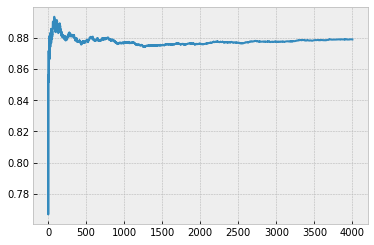

In [140]:
plt.plot(mcmc_exp2[0].get_extra_fields()['mean_accept_prob'])

In [141]:
from numpyro.infer import Predictive

random_key, random_key_ = random.split(random_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictive?
# prior_predictions = prior_predictive(rng_key_, marriage=dset.MarriageScaled.values)['obs']
# mean_prior_pred = jnp.mean(prior_predictions, axis=0)
# hpdi_prior_pred = hpdi(prior_predictions, 0.9)

# ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
# ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Predictions with 90% CI');

Signature:      prior_predictive(rng_key, *args, **kwargs)
Type:           Predictive
String form:    <numpyro.infer.util.Predictive object at 0x7fead8e80a00>
File:           ~/miniconda3/lib/python3.8/site-packages/numpyro/infer/util.py
Docstring:     
This class is used to construct predictive distribution. The predictive distribution is obtained
by running model conditioned on latent samples from `posterior_samples`.

.. warning::
    The interface for the `Predictive` class is experimental, and
    might change in the future.

:param model: Python callable containing Pyro primitives.
:param dict posterior_samples: dictionary of samples from the posterior.
:param callable guide: optional guide to get posterior samples of sites not present
    in `posterior_samples`.
:param dict params: dictionary of values for param sites of model/guide.
:param int num_samples: number of samples
:param list return_sites: sites to return; by default only sample sites not present
    in `posterior_sam

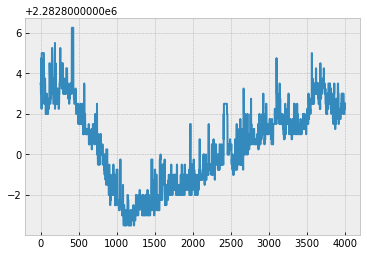

In [112]:
plt.plot(mcmc_dave_2k_warmup_4k_samples2.get_extra_fields(group_by_chain=True)['potential_energy'][0])


In [113]:
fig = plt.figure(1)
t = mcmc_dave_2k_warmup_4k_samples2.get_extra_fields(group_by_chain=True)['potential_energy']
for k in range(t):

  # add every single subplot to the figure with a for loop

  ax = fig.add_subplot(t[k])
  ax.plot(x,y)      # Or whatever you want in the subplot

plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 432x288 with 0 Axes>

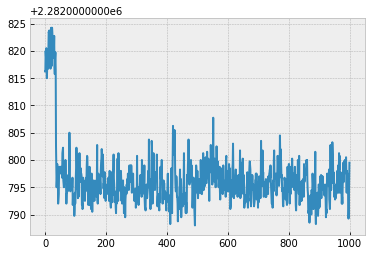

In [ ]:
dave_4chain_potential_energy = mcmc_dave.get_extra_fields(group_by_chain=True)['potential_energy']
plt.plot(dave_4chain_potential_energy[0])

In [ ]:
# Using multiple chains seems to work, in that estimates are correct
# but because of label switching, statistics are messed
# resolved below using a simple for loop and ordering parameters
random_key, _random_key = random.split(random_key)

run_params_dave_4_chains = run_params_dave.copy()
run_params_dave_4_chains['num_chains'] = 1
run_params_dave_4_chains['chain_method'] = 'vectorized'
mcmc_dave_4_chains, inferred_params_dave_4_chains = run(_random_key, run_params=run_params_dave_4_chains)

  0%|          | 0/1200 [00:00<?, ?it/s]

[3207499224 1958867714]


sample:  21%|██        | 247/1200 [00:21<01:24, 11.33it/s, 127 steps of size 5.83e-02. acc. prob=0.86] 


KeyboardInterrupt: 

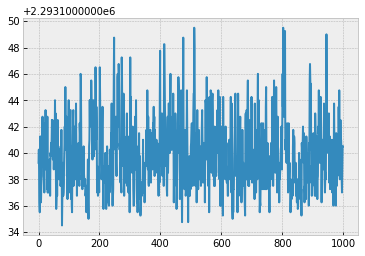

In [ ]:
dave_4chain_potential_energy = mcmc_dave_4_chains.get_extra_fields(group_by_chain=True)['potential_energy']
plt.plot(dave_4chain_potential_energy[0])

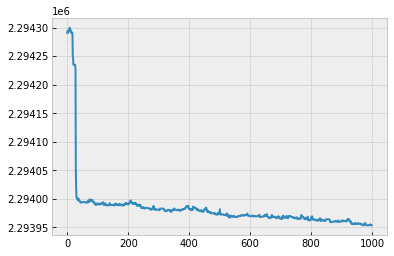

In [ ]:
plt.plot(dave_4chain_potential_energy[1])

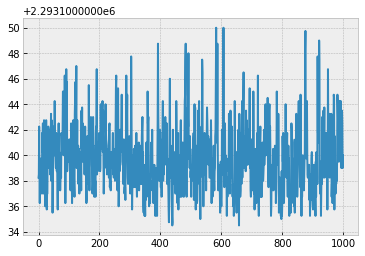

In [ ]:
plt.plot(dave_4chain_potential_energy[2])

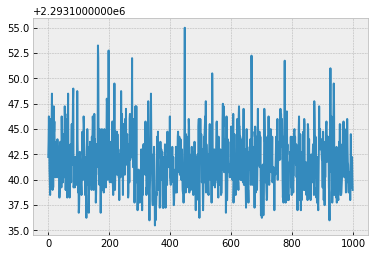

In [ ]:
plt.plot(dave_4chain_potential_energy[3])

In [ ]:
# When we group by chain, we can recover the exact same values as below when we go 1 at a time
# but more terse
mcmc_dave_4_chains.get_samples(group_by_chain=True)['beta'][0]

DeviceArray([[0.03974317, 0.83295566, 0.46318215, 1.        ],
             [0.1534026 , 0.01802589, 0.15611073, 0.08726842],
             [0.04014789, 0.7065747 , 0.4487946 , 0.0291582 ],
             [0.0871492 , 0.0421646 , 0.14730541, 0.07477561],
             [1.        , 0.9138498 , 0.87466216, 0.07472366]],            dtype=float32)

In [ ]:
# If we provide mix_weights multiple chains, we can back weights
# such that the first dimension is in length num_chains, and each inner 2D array is the array of weights for one chain
mix_weights(mcmc_dave_4_chains.get_samples(group_by_chain=True)['beta']).mean(1)

DeviceArray([[0.03974317, 0.8006831 , 0.07484905, 0.08726842],
             [0.1534026 , 0.01589329, 0.8043898 , 0.0291582 ],
             [0.04014789, 0.8009739 , 0.0867302 , 0.07477561],
             [0.0871492 , 0.04009879, 0.80092865, 0.07472366]],            dtype=float32)

In [ ]:
posterior_samples = mcmc_dave.get_samples()
probs = posterior_samples['probs']
weights = mix_weights(posterior_samples['beta'])
order = jnp.argsort(weights.mean(0))[::-1]


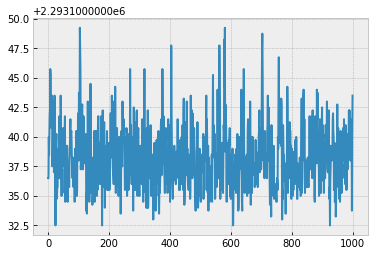

In [ ]:
plt.plot(mcmc_runs[0].get_extra_fields()['potential_energy'])

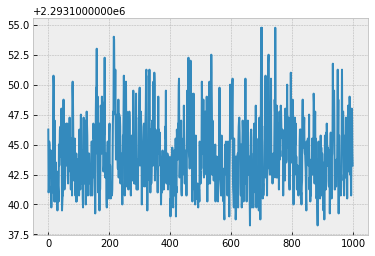

In [ ]:
plt.plot(mcmc_runs[1].get_extra_fields()['potential_energy'])

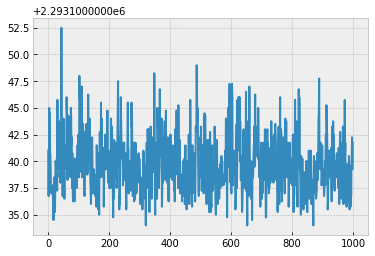

In [ ]:
plt.plot(mcmc_runs[2].get_extra_fields()['potential_energy'])

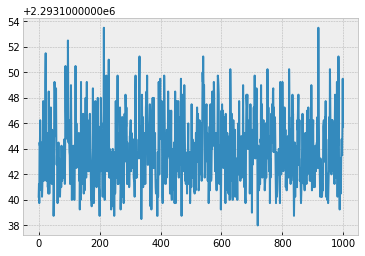

In [ ]:
plt.plot(mcmc_runs[3].get_extra_fields()['potential_energy'])

In [ ]:
# Simple ordering procedure
# We'll modify this to not argsort, but instead permute and maximize likelihood
# all_weights_ordered = []
# all_probs_ordered = []

# for mr in mcmc_runs:
#     posterior_probs = mr.get_samples()
#     probs = posterior_probs['probs']
#     betas = posterior_probs['beta']
#     weights = np.array(mix_weights(posterior_probs['beta']))
#     # don't think this is needed, since within 1 chain, order should be deterministic if solution converges
#     # desc_order = np.flip(np.argsort(weights, axis=1), axis=1)
#     first_o = None
#     probs_ordered = []
#     weights_ordered = []
#     desc_order = np.argsort(weights.mean(0))[::-1]

#     for i, prob_mcmc_sample in enumerate(probs):
#         probs_ordered.append(prob_mcmc_sample[desc_order])

#     for i, weight in enumerate(weights):
#         weights_ordered.append(weight[desc_order])

#     weights_ordered = np.array(weights_ordered)
#     probs_ordered = np.array(probs_ordered)

#     all_weights_ordered.append(weights_ordered)
#     all_probs_ordered.append(probs_ordered)

# all_weights_ordered = jnp.stack(all_weights_ordered)
# all_probs_ordered = jnp.stack(all_probs_ordered)

all_probs_ordered = ordered_statistics(mcmc_runs)

In [ ]:
all_probs_ordered.mean(1)

DeviceArray([[[0.94379747, 0.02692192, 0.02667435, 0.00260632],
              [0.84960264, 0.11822584, 0.02398419, 0.00818741],
              [0.8541171 , 0.01987891, 0.11898154, 0.00702249],
              [0.7950764 , 0.08179998, 0.1003232 , 0.02280047]],

             [[0.9438389 , 0.02692099, 0.02663066, 0.0026095 ],
              [0.84980345, 0.11811214, 0.02392472, 0.00815973],
              [0.85412   , 0.01999238, 0.11885422, 0.00703342],
              [0.7949942 , 0.08208641, 0.09997423, 0.02294521]],

             [[0.9438234 , 0.02691982, 0.02664693, 0.00260988],
              [0.84972465, 0.11809751, 0.02397444, 0.00820347],
              [0.85394305, 0.01995317, 0.11908593, 0.00701794],
              [0.7949185 , 0.08202976, 0.10008179, 0.02297001]],

             [[0.94382966, 0.02689509, 0.02666532, 0.00261002],
              [0.849838  , 0.11798475, 0.02401154, 0.00816582],
              [0.8539219 , 0.02005435, 0.11894427, 0.0070795 ],
              [0.7944804 , 0.08224

In [ ]:
all_probs_ordered.mean(1).mean(0)

DeviceArray([[0.9438224 , 0.02691445, 0.02665432, 0.00260893],
             [0.84974223, 0.11810505, 0.02397372, 0.00817911],
             [0.85402554, 0.01996971, 0.11896649, 0.00703834],
             [0.79486734, 0.08204134, 0.10013697, 0.0229544 ]],            dtype=float32)

In [ ]:
all_probs_ordered.std(1).mean(0)

DeviceArray([[4.0788655e-04, 2.7984206e-04, 2.8313434e-04, 7.3229734e-05],
             [2.5032221e-03, 2.3677263e-03, 1.0725479e-03, 4.8063693e-04],
             [2.8957110e-03, 1.1837400e-03, 2.6834686e-03, 5.4276420e-04],
             [5.0061061e-03, 3.3953309e-03, 3.6340312e-03, 1.4145083e-03]],            dtype=float32)

In [ ]:
all_weights_ordered.mean(1)

DeviceArray([[0.80135596, 0.08686166, 0.07449117, 0.03918914],
             [0.8005134 , 0.08709402, 0.07556511, 0.03959268],
             [0.8008574 , 0.08732204, 0.07512773, 0.03912302],
             [0.8004355 , 0.08764718, 0.07549501, 0.03917028]],            dtype=float32)

In [ ]:
all_weights_ordered.std(1)

DeviceArray([[0.00840331, 0.02922745, 0.0116053 , 0.01013913],
             [0.0085703 , 0.0268208 , 0.02960934, 0.02555379],
             [0.00742889, 0.02921478, 0.02963395, 0.01114255],
             [0.00831091, 0.02918947, 0.02663886, 0.02537283]],            dtype=float32)

In [ ]:
all_weights_ordered.mean(1).mean(0)

DeviceArray([0.80079055, 0.08723123, 0.07516976, 0.03926878], dtype=float32)

In [ ]:
all_weights_ordered.std(1).mean(0)

DeviceArray([0.00817835, 0.02861313, 0.02437186, 0.01805207], dtype=float32)

In [ ]:
mcmc_runs[1].get_samples()['probs'].mean(0)

DeviceArray([[0.85412   , 0.01999238, 0.11885422, 0.00703342],
             [0.84980345, 0.11811214, 0.02392472, 0.00815973],
             [0.7949942 , 0.08208641, 0.09997423, 0.02294521],
             [0.9438389 , 0.02692099, 0.02663066, 0.0026095 ]],            dtype=float32)

In [ ]:
df.mean(0) / df.mean(0).sum()

Per_Gene_Counts_Unaffected_Unaffected    0.923342
Unaffected_Affected                      0.036376
Affected_Unaffected                      0.036082
Affected_Affected                        0.004199
dtype: float64

In [ ]:
weights_ordered

[DeviceArray([[0.79907304, 0.3961953 , 0.32799867, 1.        ],
              [0.80606556, 0.07243318, 0.03614398, 0.08491538],
              [0.80146897, 0.08024991, 0.03932683, 0.08152764],
              [0.80200976, 0.07338683, 0.03810923, 0.0805863 ]],            dtype=float32),
 DeviceArray([[0.07315207, 0.09127847, 0.03701135, 0.8023574 ],
              [0.07321888, 0.09119258, 0.04274708, 0.8017384 ],
              [0.07229436, 0.09120882, 0.04904849, 1.        ],
              [0.07400815, 0.08388129, 0.03951712, 0.79330814]],            dtype=float32),
 DeviceArray([[0.08751276, 0.8017656 , 0.04300737, 0.07227262],
              [0.0834271 , 0.87747276, 0.35646215, 1.        ],
              [0.0798614 , 0.7993265 , 0.0329809 , 0.07342913],
              [0.09174296, 0.7961394 , 0.04182569, 0.07052594]],            dtype=float32),
 DeviceArray([[0.08598123, 0.08364831, 0.03527716, 0.8071271 ],
              [0.08318748, 0.08285195, 0.04397435, 1.        ],
              [0.081

In [ ]:
weights[order].mean(0)

DeviceArray([0.7949562 , 0.15647884, 0.24578184, 0.27627927], dtype=float32)

In [ ]:
probs[order].mean(0)

DeviceArray([[0.94404763, 0.02664005, 0.02671997, 0.00259234],
             [0.8537455 , 0.02067028, 0.1186259 , 0.00695827],
             [0.85110986, 0.11692996, 0.02395056, 0.0080096 ],
             [0.7904475 , 0.08320437, 0.10247807, 0.02387012]],            dtype=float32)

In [ ]:
inferred_params_dave[0]

{'beta': DeviceArray([[0.7947298 , 0.3910561 , 0.70708513],
              [0.7925506 , 0.39152628, 0.7343214 ],
              [0.7961972 , 0.37936127, 0.7235521 ],
              ...,
              [0.8096116 , 0.33503208, 0.6333263 ],
              [0.80289584, 0.3941263 , 0.73739743],
              [0.8047103 , 0.4069674 , 0.70386535]], dtype=float32),
 'probs': DeviceArray([[[0.94387954, 0.02683692, 0.02666332, 0.00262021],
               [0.85495454, 0.02126331, 0.11755291, 0.00622924],
               [0.8491688 , 0.1184563 , 0.02421224, 0.00816269],
               [0.79466313, 0.07855606, 0.10397497, 0.02280584]],
 
              [[0.94450647, 0.02661596, 0.02640774, 0.00246983],
               [0.85219854, 0.02080397, 0.11861727, 0.00838022],
               [0.85097104, 0.11675541, 0.02437702, 0.00789653],
               [0.79020137, 0.08939447, 0.09777569, 0.02262848]],
 
              [[0.94384885, 0.02658884, 0.02689906, 0.00266325],
               [0.85550123, 0.01928418, 0.11

In [ ]:
def test():
    
mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave, postprocess_fn= )

IndentationError: expected an indented block (<ipython-input-44-c5a467ac574a>, line 3)

In [ ]:
run_params_daveb = run_params_dave.copy()
run_params_daveb['max_K'] = 50
mcmc_daveb, inferred_params_daveb = run(sim_data={}, run_params=run_params_daveb)

sample: 100%|██████████| 1200/1200 [00:22<00:00, 52.68it/s, 11 steps of size 4.18e-02. acc. prob=0.69] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.01      0.01      0.00      0.00      0.03      4.30      1.72
    beta[1]      0.01      0.01      0.01      0.00      0.02     16.48      1.20
    beta[2]      0.03      0.00      0.03      0.02      0.04      8.54      1.04
    beta[3]      0.04      0.03      0.03      0.00      0.08      6.22      1.32
    beta[4]      0.02      0.01      0.02      0.00      0.05      3.75      1.83
    beta[5]      0.05      0.01      0.05      0.03      0.07     10.25      1.01
    beta[6]      0.71      0.06      0.71      0.60      0.81      5.17      1.52
    beta[7]      0.00      0.00      0.00      0.00      0.01     12.59      1.00
    beta[8]      0.49      0.11      0.51      0.31      0.66      5.91      1.57
    beta[9]      0.59      0.06      0.59      0.51      0.72     13.53      1.15
   beta[10]      0.88      0.07      0.89      0.78      0.97      9.24      1.14
   beta[11]    

In [ ]:
run_params_daveb = run_params_dave.copy()
run_params_daveb['max_K'] = 100
run_params_daveb['num_warmup'] = 1000
run_params_daveb['num_samples'] = 10000
mcmc_daveb, inferred_params_daveb = run(sim_data={}, run_params=run_params_daveb)

sample: 100%|██████████| 11000/11000 [01:50<00:00, 99.21it/s, 19 steps of size 2.66e-02. acc. prob=0.64] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.07      0.07      0.06      0.00      0.17      3.95      1.84
    beta[1]      0.04      0.01      0.04      0.03      0.05      6.00      1.36
    beta[2]      0.00      0.00      0.00      0.00      0.00      8.80      1.16
    beta[3]      0.81      0.02      0.81      0.79      0.84      9.26      1.00
    beta[4]      0.45      0.04      0.44      0.39      0.50      5.35      1.58
    beta[5]      0.03      0.05      0.01      0.00      0.11      4.65      1.44
    beta[6]      0.10      0.09      0.08      0.00      0.24      4.90      1.21
    beta[7]      0.00      0.00      0.00      0.00      0.00      7.61      1.74
    beta[8]      0.92      0.04      0.92      0.86      0.97     23.81      1.04
    beta[9]      0.23      0.18      0.18      0.00      0.50     38.92      1.03
   beta[10]      0.37      0.29      0.30      0.01      0.85      7.60      1.23
   beta[11]    

In [ ]:
numpyro.enable_x64(False)
run_params_dave_6 = run_params_dave.copy()
run_params_dave_6['max_K'] = 6
mcmc_dave_6, inferred_params_dave_6 = run(sim_data={}, run_params=run_params_dave_6)

sample: 100%|██████████| 1200/1200 [01:05<00:00, 18.46it/s, 127 steps of size 3.50e-02. acc. prob=0.59]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.79      0.01      0.79      0.77      0.80    181.94      1.01
   beta[1]      0.33      0.04      0.34      0.26      0.38     10.36      1.05
   beta[2]      0.13      0.06      0.14      0.02      0.22     24.75      1.05
   beta[3]      0.31      0.03      0.32      0.27      0.36    165.15      1.00
   beta[4]      0.98      0.04      1.00      0.97      1.00     32.87      1.04
probs[0,0]      0.94      0.00      0.94      0.94      0.94     25.03      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03     25.64      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03     17.39      1.01
probs[0,3]      0.00      0.00      0.00      0.00      0.00     76.80      1.01
probs[1,0]      0.85      0.01      0.85      0.84      0.86     10.13      1.09
probs[1,1]      0.02      0.00      0.02      0.02      0.02    123.96      1.00
probs[1,2]      0.12      0

In [ ]:
from jax import random
from numpyro.distributions import MultivariateNormal, Normal
from jax.nn import softmax, softplus
from numpyro import *
rng_key = random.PRNGKey(0)
import numpy as np
from scipy.stats import norm

print("pd_with_both", pd_with_both)

with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    print( 1- np.array(pd_with_both))
    z_scores = Normal(0,1).icdf(np.array(pd_with_both))
    x = numpyro.sample('x', MultivariateNormal(z_scores, 1.), sample_shape=(100,4))    # uses a PRNGKey split from random.PRNGKey(0)
    print("x:", x)
    print(softmax(x, 1))

pd_with_both tensor([0.9416, 0.0280, 0.0280, 0.0024])
[0.05839998 0.972      0.972      0.9976    ]
x: [[[ 2.546823   -0.9325607  -0.9325607  -1.841683  ]
  [ 2.2777395  -1.201644   -1.201644   -2.1107664 ]
  [ 3.1553988  -0.32398486 -0.32398486 -1.2331072 ]
  [ 1.0925624  -2.3868213  -2.3868213  -3.2959435 ]]

 [[ 1.5714732  -1.9079103  -1.9079103  -2.8170328 ]
  [ 1.8544437  -1.6249399  -1.6249399  -2.5340624 ]
  [ 1.1376345  -2.3417492  -2.3417492  -3.2508714 ]
  [ 0.13627589 -3.3431077  -3.3431077  -4.25223   ]]

 [[ 2.8981075  -0.58127606 -0.58127606 -1.4903984 ]
  [ 2.320273   -1.1591108  -1.1591108  -2.068233  ]
  [ 3.0375624  -0.44182122 -0.44182122 -1.3509436 ]
  [ 1.629484   -1.8498995  -1.8498995  -2.7590218 ]]

 ...

 [[ 0.9039824  -2.5754013  -2.5754013  -3.4845235 ]
  [ 2.380455   -1.0989287  -1.0989287  -2.008051  ]
  [ 1.9188781  -1.5605056  -1.5605056  -2.4696279 ]
  [ 2.998932   -0.4804517  -0.4804517  -1.389574  ]]

 [[ 1.2266941  -2.2526896  -2.2526896  -3.1618118 ]

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295,0.043475,0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "target_accept_prob": .8,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc_dave, inferred_params_dave= run(sim_data={}, run_params=run_params_dave)

alpha 0.05
alpha 0.05


  0%|          | 0/1200 [00:00<?, ?it/s]

alpha 0.05


sample: 100%|██████████| 1200/1200 [00:07<00:00, 166.12it/s, 7 steps of size 3.88e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.88      0.00      0.88      0.87      0.88    703.44      1.00
   beta[1]      0.33      0.01      0.33      0.32      0.35    791.51      1.00
   beta[2]      0.50      0.01      0.50      0.48      0.53   1031.01      1.00
probs[0,0]      0.92      0.00      0.92      0.92      0.92   1381.03      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03   1694.36      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03   1788.45      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01   1346.82      1.00
probs[1,0]      0.73      0.00      0.73      0.73      0.74   1177.90      1.00
probs[1,1]      0.01      0.00      0.01      0.01      0.02   1782.41      1.00
probs[1,2]      0.22      0.00      0.22      0.22      0.23   1061.52      1.00
probs[1,3]      0.03      0.00      0.03      0.03      0.03    730.31      1.00
probs[2,0]      0.73      0

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295,0.043475,0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave50 = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "target_accept_prob": .9,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc_dave50, inferred_params_dave50 = run(sim_data={}, run_params=run_params_dave50)

NameError: name 'model' is not defined

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295,0.043475,0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave502 = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "target_accept_prob": .8,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc_dave502, inferred_params_dave502= run(sim_data={}, run_params=run_params_dave502)

sample: 100%|██████████| 1200/1200 [00:49<00:00, 24.20it/s, 7 steps of size 2.09e-02. acc. prob=0.78]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.00      0.00      0.00      0.00      0.00     18.77      1.01
    beta[1]      0.01      0.01      0.01      0.00      0.02      9.53      1.03
    beta[2]      0.02      0.00      0.02      0.01      0.03      2.97      1.95
    beta[3]      0.03      0.00      0.03      0.02      0.04      9.98      1.01
    beta[4]      0.00      0.00      0.00      0.00      0.00     32.05      1.00
    beta[5]      0.00      0.00      0.00      0.00      0.01     19.89      1.07
    beta[6]      0.89      0.01      0.89      0.88      0.90      5.56      1.18
    beta[7]      0.22      0.03      0.22      0.16      0.26      5.52      1.10
    beta[8]      0.34      0.03      0.34      0.29      0.38      7.03      1.24
    beta[9]      0.04      0.04      0.03      0.00      0.09     19.72      1.00
   beta[10]      0.02      0.01      0.02      0.00      0.04     10.07      1.00
   beta[11]    

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295,0.043475,0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave503 = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 10,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "target_accept_prob": .8,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc_dave503, inferred_params_dave503= run(sim_data={}, run_params=run_params_dave503)

sample: 100%|██████████| 1200/1200 [00:30<00:00, 39.85it/s, 18 steps of size 8.19e-02. acc. prob=0.70] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.00      0.00      0.00      0.00      0.00     10.23      1.08
    beta[1]      0.02      0.00      0.02      0.02      0.02      8.45      1.14
    beta[2]      0.02      0.00      0.02      0.02      0.03     17.81      1.00
    beta[3]      0.03      0.00      0.03      0.02      0.03     19.94      1.00
    beta[4]      0.00      0.00      0.00      0.00      0.00      8.04      1.13
    beta[5]      0.00      0.00      0.00      0.00      0.01     16.10      1.00
    beta[6]      0.90      0.02      0.91      0.87      0.92      5.12      1.37
    beta[7]      0.15      0.15      0.09      0.00      0.42      3.50      1.63
    beta[8]      0.06      0.08      0.02      0.00      0.18     12.85      1.02
    beta[9]      0.01      0.01      0.01      0.00      0.02     16.35      1.01
   beta[10]      0.35      0.03      0.35      0.31      0.39     14.10      1.02
   beta[11]    

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295,0.043475,0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave504 = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 10,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "target_accept_prob": .8,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc_dave504, inferred_params_dave504= run(sim_data={}, run_params=run_params_dave504)

sample: 100%|██████████| 1200/1200 [00:24<00:00, 48.45it/s, 12 steps of size 8.20e-02. acc. prob=0.70] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.03      0.00      0.03      0.02      0.03     30.89      1.00
    beta[1]      0.02      0.00      0.02      0.02      0.03      9.45      1.00
    beta[2]      0.03      0.00      0.03      0.03      0.04      7.50      1.43
    beta[3]      0.00      0.00      0.00      0.00      0.01      8.88      1.19
    beta[4]      0.02      0.00      0.02      0.01      0.02      7.02      1.32
    beta[5]      0.03      0.00      0.03      0.02      0.03      8.81      1.28
    beta[6]      0.98      0.00      0.98      0.97      0.98     14.01      1.22
    beta[7]      0.02      0.02      0.01      0.00      0.04      3.87      1.55
    beta[8]      0.90      0.04      0.90      0.85      0.97      7.25      1.35
    beta[9]      0.48      0.22      0.48      0.13      0.81     19.25      1.01
   beta[10]      0.34      0.23      0.26      0.09      0.76      3.74      1.48
   beta[11]    

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295,0.043475,0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave6 = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 6,
    "target_accept_prob": .9,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc_dave6, inferred_params_dave6 = run(sim_data={}, run_params=run_params_dave6)

sample: 100%|██████████| 1200/1200 [00:13<00:00, 90.52it/s, 15 steps of size 2.43e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.87      0.00      0.87      0.86      0.87    426.01      1.00
   beta[1]      0.30      0.01      0.30      0.28      0.32    653.00      1.00
   beta[2]      0.17      0.03      0.17      0.13      0.21    350.03      1.00
   beta[3]      0.42      0.03      0.42      0.37      0.47    303.02      1.00
   beta[4]      0.36      0.04      0.36      0.29      0.42    161.11      1.00
probs[0,0]      0.92      0.00      0.92      0.92      0.93    895.51      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03    770.42      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03   1257.45      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01   2177.42      1.00
probs[1,0]      0.73      0.00      0.73      0.73      0.74   1440.24      1.00
probs[1,1]      0.01      0.00      0.01      0.01      0.01   1162.50      1.00
probs[1,2]      0.22      0

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295,0.043475,0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave12 = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "target_accept_prob": .9,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc_dave12, inferred_params_dave12 = run(sim_data={}, run_params=run_params_dave12)

  0%|          | 0/1200 [00:00<?, ?it/s]

alpha 0.05
alpha 0.05
alpha 0.05


sample: 100%|██████████| 1200/1200 [00:07<00:00, 154.79it/s, 7 steps of size 3.63e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.88      0.00      0.88      0.87      0.88   1049.46      1.00
   beta[1]      0.33      0.01      0.33      0.32      0.35    908.10      1.00
   beta[2]      0.50      0.01      0.50      0.48      0.52   1059.06      1.00
probs[0,0]      0.92      0.00      0.92      0.92      0.92   1583.99      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03   1181.86      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03   1468.12      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01   1719.44      1.00
probs[1,0]      0.73      0.00      0.73      0.73      0.74    925.87      1.00
probs[1,1]      0.01      0.00      0.01      0.01      0.02   1393.05      1.00
probs[1,2]      0.22      0.00      0.22      0.22      0.23    935.17      1.00
probs[1,3]      0.03      0.00      0.03      0.03      0.03    725.82      1.00
probs[2,0]      0.73      0

In [ ]:
from numpyro.infer import Predictive, SVI, Trace_ELBO, TraceGraph_ELBO, TraceEnum_ELBO
guide = AutoMultivariateNormal(model)
optimizer = numpyro.optim.Adam(step_size=0.0005)
svi = SVI(model, guide, optimizer,loss=Trace_ELBO())

svi_result = svi.run(random.PRNGKey(0), 2000, stat_data_dave, n_cases, n_ctrls, 4, .05)
svi_result

ImportError: cannot import name 'TraceEnum_ELBO' from 'numpyro.infer' (/home/akotlar/miniconda3/lib/python3.8/site-packages/numpyro/infer/__init__.py)

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295,0.043475,0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
print(n_cases)
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "target_accept_prob": .9,
    "chain_method": 'parallel',
    "model_to_run": model_conjugate,
    "jit_model_args": False
}

mcmc_davec, inferred_params_davec = run(sim_data={}, run_params=run_params_dave)

[8590. 8695. 2495.]


sample: 100%|██████████| 1200/1200 [00:35<00:00, 34.02it/s, 15 steps of size 2.39e-01. acc. prob=0.92] 



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
            beta[0]      0.04      0.00      0.04      0.04      0.04   1953.89      1.00
            beta[1]      0.91      0.00      0.91      0.91      0.92   1521.57      1.00
            beta[2]      0.50      0.01      0.50      0.48      0.53   1398.57      1.00
concentrations[0,0]      0.95      0.03      0.95      0.90      0.99   1635.62      1.00
concentrations[0,1]      0.44      0.24      0.41      0.06      0.81   1568.29      1.00
concentrations[0,2]      0.62      0.24      0.65      0.26      0.99    991.89      1.00
concentrations[0,3]      0.50      0.25      0.49      0.08      0.87   1289.19      1.00
concentrations[1,0]      0.95      0.03      0.95      0.91      1.00   1190.03      1.00
concentrations[1,1]      0.50      0.25      0.48      0.07      0.88   1823.81      1.00
concentrations[1,2]      0.50      0.26      0.48      0.14      0.96   1849.30      1.00
concentra

In [ ]:
print(inferred_params_davec[0]['concentrations'][0])
print(inferred_params_davec[0]['probs'][0])

[[0.9313233  0.07006516 0.25348118 0.39937803]
 [0.9898198  0.10834241 0.18314637 0.58913827]
 [0.9149957  0.05955306 0.14527872 0.45817325]
 [0.9691906  0.643084   0.2537242  0.18951987]]
[[0.73457366 0.01494129 0.2189597  0.03152536]
 [0.92420614 0.03214889 0.03120701 0.01243796]
 [0.7324655  0.22322379 0.01275728 0.03155342]
 [0.62156373 0.12058114 0.12953444 0.12832068]]


In [ ]:
inferred_params_davec[0]['probs'].mean(0)

DeviceArray([[0.7329962 , 0.01389898, 0.2216587 , 0.03144608],
             [0.9237677 , 0.032288  , 0.03135124, 0.01259311],
             [0.72630006, 0.22789992, 0.01352686, 0.03227315],
             [0.6223789 , 0.12285706, 0.12628713, 0.12847702]],            dtype=float32)

In [ ]:
inferred_params_davec[0]['concentrations'].mean(0)

DeviceArray([[0.9508699 , 0.44004226, 0.6195561 , 0.50679225],
             [0.95238423, 0.49198768, 0.49838364, 0.43341196],
             [0.95030814, 0.6131735 , 0.45277235, 0.49131912],
             [0.95191276, 0.58464867, 0.5758162 , 0.5891459 ]],            dtype=float32)

We have 4 different categories of states
With probability pi_1 (disease 1 affected by gene), the gene affects disease 1. we have individuals affected by gene 1 with penetrance P(D|A1). Individuals affected by both also get P(D|A1), I think

With probability pi_2 (disease 2 affected by gene), the gene affects disease 2. we have individuals affected by disease 2 with penetrance P(D|A2). Individuals affected by both also get P(D|A2), I think

With probability pi_3, diseases 1 and 2 affected by the gene. Individuals with disease 1, 2, and both get P(D|ABoth), I think. 

I think we keep all penetrances independent.

I think that we actually get P(V|D1)?

In [ ]:
samples = np.array([n_ctrls, *n_cases])
sample_proportions = samples / samples.sum()
sample_proportions

penetrances = inferred_params_davec[0]['probs'].mean(0) / sample_proportions
print(penetrances)

# Dude this isn't penetrance! From  cureffi.org:
#P(D|A) = P(D) * P(A|D)/P(A)
# where p(A|D) = allele frequency in cases
# where P(A) is the allele frequency in population controls
# and
# penetrance = baseline risk * case allele frequency / population control allele frequency

# and the in-sample estimate of P(D) is the number of cases / total number of samples

# so when we get something like
# [[ 0.8134461   0.32360843  5.0985327   2.520728  ]
#  [ 1.0251557   0.75175786  0.7211326   1.0094681 ]
#  [ 0.80601496  5.306168    0.31114104  2.587026  ]
#  [ 0.69068795  2.8604672   2.904822   10.298759  ]]
# we can see that we've estimated say for component 2 that case allele frequency / population control allele frequency is larger
# penetrance = rr * P(D|~V) as well
# and P(D) = P(D|V)P(V) + P(D|~V)P(~V)
# population control allele frequency = P(A) = P(V|~D)

# P(D|V) / ( P(D|V)P(V) + P(D|~V)P(~V)) = P(V|D) / P(V|~D)

# P(V|D)P(D) = P(D|V)P(V)
# P(V|D) = P(D|V)P(V)/P(D)

# so my above calculation is close to P(V|D), off by the allele frequency

[[ 0.8134461   0.32360843  5.0985327   2.520728  ]
 [ 1.0251557   0.75175786  0.7211326   1.0094681 ]
 [ 0.80601496  5.306168    0.31114104  2.587026  ]
 [ 0.69068795  2.8604672   2.904822   10.298759  ]]


In [ ]:
# alpha1 = thres = Invs_Cumulative_Normal( 1 - Pv )
# Pv = prevalence of disease 1
# 0.04295 is prevalence of disease 1

# Why isn't this working?
samples = [n_ctrls, **n_cases]
d = dist.Normal(0, 1)

# for disease2 the penetrance should be the thing that is highest, after scaling by sample proportion I think for in
# we expect a pattern 
thresh1 = None
with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    pd1 = .04295
    thresh1 = d.icdf(1-.04295)

    alpha1 = thresh1 - 

SyntaxError: invalid syntax (<ipython-input-28-71fbff726521>, line 16)

In [ ]:
from mvl2.infer import mix_weights, get_weights_from_mcmc_samples_beta

inferred_params_dave = inferred_params_davec
mcmc_dave = mcmc_davec
beta = inferred_params_dave[0]['beta']
print('beta', beta[-1])
print('beta.shape', beta.shape)
weights = get_weights_from_mcmc_samples_beta(beta)

# not sure why weights here is 1001, 4), given that beta is 1000,3

# shape is (1001, 4)
print('weights.shape', weights.shape)

# shape is (50, )
print('weights.mean(0).shape', weights.mean(0).shape)
print('weights.mean(0)', weights.mean(0))

selected_components = weights.mean(0) >= 9e-3
print('selected_components', selected_components)
# print('weights.mean(0)[selected_components].sort()[::-1]', weights.mean(0)[selected_components].sort()[::-1])
# print(np.nonzero(selected_components))

selected_probs = mcmc_dave.get_samples()['probs'][:, selected_components, :]


component1 = selected_probs[:, :, :]
print('pd_with_both', pd_with_both)
print('component1.mean(0)', component1.mean(0))

probs = inferred_params_dave[0]['probs']
print("probs.mean(0)[selected_components]", probs.mean(0)[selected_components])
# (3001, 100)
# (100,)
# [0.79759234 0.07203006 0.05195475 0.02510345 0.02443778 0.01053052
#  0.0054377 ]]
# 100 components infers as well, roughly as 50. But now 2 extra components, not 1

beta [0.03977534 0.9127851  0.49587533]
beta.shape (1000, 3)
weights.shape (1000, 4)
weights.mean(0).shape (4,)
weights.mean(0) [0.04109853 0.8766369  0.04132231 0.04094182]
selected_components [ True  True  True  True]
pd_with_both [0.9011   0.04295  0.043475 0.012475]
component1.mean(0) [[0.7329962  0.01389898 0.2216587  0.03144608]
 [0.9237677  0.032288   0.03135124 0.01259311]
 [0.72630006 0.22789992 0.01352686 0.03227315]
 [0.6223789  0.12285706 0.12628713 0.12847702]]
probs.mean(0)[selected_components] [[0.7329962  0.01389898 0.2216587  0.03144608]
 [0.9237677  0.032288   0.03135124 0.01259311]
 [0.72630006 0.22789992 0.01352686 0.03227315]
 [0.6223789  0.12285706 0.12628713 0.12847702]]


In [ ]:
stat_data_dave

# Prevalence of disease 1
# = 

concentration_a1 = inferred_params_davec[0]['concentrations'].mean(0)[0]

add_them = []
with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    for i in range(20_000):
        prob = numpyro.sample(f'prob_gene_{i}', dist.Dirichlet(concentration_a1))
        add_them.append(prob)
        

        if i < 5:
            print(prob)

np.array(add_them).mean(0)
stat_data_dave.mean(0)

array([35.8165 ,  1.7329 ,  1.69305,  0.75755])

In [ ]:
# P(D|~V) = P(D|~V)P(~V)
# P(D) = Sum( P(D|V)P(V) ) over all V, which are the architectures (rare allele count sums)
# P(D|~V) this is prevalence as well? It can't be, must be 1 - sum (P(D|V)P(V)) over everything other than ~V, then / P(~V)
# P(V|D) = P(D|V)P(V) / P(D)
# pdv_pv_null = probs.mean(0)[selected_components]
# 
# alpha1 = freq(a1a1) * average(phenotype of a1a1 invididulal) + .5 * freq(a1a2) * average(phenotype of a1a2 individuals)/p

# alpha2 = -p * alpah1 / q
# alpha1 = thres - inv_cum_normal( 1 - P(D|A1))

# alpah2 = -p*alpha / q
# Variance due to locus is 2*(p*alpah1^2 + q*alpha2)

# For 2 phenotypes, you can calculate the alphas independently for the two traits based on the pentrance of the a1 allele for both traits (a1 allele here is a collection of rare alleles)

# penetrance is P(D|V), or here, P(D|A12) I think

multinomial_probs = probs.mean(0)[selected_components]
multinomial_probs
# The probability at a locus in P(D|V) = P(V|D)P(D)/P(V)
# dv_pv_one = probs.mean(1)[selected_components]
# dv_pv_other = probs.mean(2)[selected_components]
# dv_pv_both = probs.mean(3)[selected_components]
# dv_pv_both
null = multinomial_probs[0,:]
print('null', null)
a1 = multinomial_probs[1,:]
print('a1', a1)
a2 = multinomial_probs[2,:]
print("a2", a2)
a12 = multinomial_probs[3,:]
print("a12", a12)

# these are the proportions of genes that are configured in each way
# are these P(D)? are these P(V)?
# Well, the full likelihood is P(D) = P(D|V)P(V) + P(D2|V)(P|V) + P(D12|V)P(V) right? or is P(V|D)

print("pis", weights.mean(0))

null [0.7329962  0.01389898 0.2216587  0.03144608]
a1 [0.9237677  0.032288   0.03135124 0.01259311]
a2 [0.72630006 0.22789992 0.01352686 0.03227315]
a12 [0.6223789  0.12285706 0.12628713 0.12847702]
pis [0.04109853 0.8766369  0.04132231 0.04094182]


In [ ]:
# 0.00010000000000000002
print('(stat_data_dave/ (200_000 * 2)).mean(0).sum()', (stat_data_dave/ (200_000 * 2)).mean(0).sum())

# array([8.954125e-05, 4.332250e-06, 4.232625e-06, 1.893875e-06])
# These are P(V|D) and P(D) is pi?
# No, I think these are P(V|D)P(D) so that their sum, is P(V)
(stat_data_dave/ (200_000 * 2)).mean(0)

(stat_data_dave/ (200_000 * 2)).mean(0).sum() 0.00010000000000000002


array([8.954125e-05, 4.332250e-06, 4.232625e-06, 1.893875e-06])

In [ ]:
weights[-1]

DeviceArray([1.        , 0.12503296, 0.08278266, 0.04082222], dtype=float32)

In [ ]:
# Ok, let's assume that this is true, then P(V|D)P(D) summed is P(V)
# well, since null * 1e-4 gives numbers very close to N*2, it's probably P(D|V)
# So we are estimating penetrance
print('null * 1e-4: ', (null * 1e-4).sum())
# If so then this is P(D|V)P(V); then pi is P(H1 (H1 affects disease 1)), and maybe the P(V) P(D|V) means probability of disease given the variat affects disease 1 (It's really P(D|V,H1))

# Dave wrote that alphas can be calculated based on the penetrance of the a1 allele for both traits
# we estimate the penetrance of the a1 allele for both traits in the a12 component
#alpha1 = thres - inv_cum_normal( 1 - P(D|A1))
# assuming he means A12, let's use a12, which is P(D|a12)
# I think it may be more appropriate to just recognize that P(D|A1) = P(D|A1, H1)P(H1) + P(D|A1, H12)P(H12)
penetrance_d1_given_a1 = a1 * weights[1]
print('penetrance_d1_given_a1', penetrance_d1_given_a1)

penetrance_d1_given_a1_smear = a1 * (weights[1] / weights.sum()) + a12 * (weights[3] / weights.sum())
print('penetrance_d1_given_a1_smear', penetrance_d1_given_a1_smear)
print('weights shape', weights.shape)
print("probs.shape", probs.shape)
print('probs[0]', probs[0])
full_smear2 = (probs * weights).mean(0)
print("full_smear", full_smear2)

# P(D1|V) = P(D1|V1)P(V1) + P()
# I don't know if it's the 2nd entry, or 2nd + 4th that's needed
# Let's just say it's P(D1|V)
penetrance_d1_smear = full_smear2[1][1]
print('penetrance_d1_smear', penetrance_d1_smear)

penetrance_d1 = a1[1]
print(penetrance_d1)

null * 1e-4:  1e-04
penetrance_d1_given_a1 [0.03743668 0.02837791 0.00125982 0.00050864]
penetrance_d1_given_a1_smear [6.1417479e-05 1.3598680e-04 6.7523174e-06 5.9162498e-06]
weights shape (1000, 4)
probs.shape (1000, 4, 4)
probs[0] [[0.73251665 0.01491535 0.22021915 0.03234885]
 [0.9238144  0.03219275 0.03140119 0.01259165]
 [0.73350227 0.22152267 0.01273333 0.03224173]
 [0.61508346 0.12375504 0.13048652 0.13067499]]


ValueError: Incompatible shapes for broadcasting: ((1000, 4, 4), (1, 1000, 4))

In [ ]:
d1_penetrance_smear = []
for i, p in enumerate(probs):
    w = weights[i]
    print('p', p)
    print('w', w)
    print("w*p", w*p)

p [[0.9234376  0.03232613 0.031464   0.01277227]
 [0.72973496 0.01315278 0.22651614 0.03059612]
 [0.71832955 0.2354817  0.01267695 0.03351181]
 [0.6211157  0.12542556 0.12569167 0.1277671 ]]
w [0.87370604 0.04132177 0.04096097 0.04401122]
w*p [[8.0681300e-01 1.3357727e-03 1.2887962e-03 5.6212331e-04]
 [6.3757384e-01 5.4349622e-04 9.2783216e-03 1.3465725e-03]
 [6.2760890e-01 9.7305197e-03 5.1926030e-04 1.4748956e-03]
 [5.4267251e-01 5.1828055e-03 5.1484532e-03 5.6231860e-03]]
p [[0.9243619  0.03208159 0.03120869 0.01234784]
 [0.73637146 0.01539069 0.21698299 0.03125487]
 [0.7279326  0.22785802 0.01270842 0.03150099]
 [0.62347037 0.12103017 0.12530865 0.1301908 ]]
w [0.87667274 0.041332   0.04203728 0.03995798]
w*p [[8.1036288e-01 1.3259964e-03 1.3119283e-03 4.9339473e-04]
 [6.4555681e-01 6.3612801e-04 9.1213742e-03 1.2488813e-03]
 [6.3815862e-01 9.4178282e-03 5.3422729e-04 1.2587158e-03]
 [5.4657948e-01 5.0024195e-03 5.2676345e-03 5.2021611e-03]]
p [[0.92349404 0.03247678 0.03144058 0.0

In [ ]:
# Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
# Args val: 0.02,0.02,200000,20000,0.0001,0.05,0.05,0.4,0.8,0.8,0,pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.4_h2_1_0.8_h2_2_0.8_rho_0/results.csv
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.4_h2_1_0.8_h2_2_0.8_rho_0/results.csv')
pds = np.array([0.03248,0.031805,0.01384])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_rho0, inferred_params_dave_rho0 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [06:28<00:00,  3.09it/s, 1023 steps of size 4.75e-03. acc. prob=0.92]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.56      0.01      0.56      0.54      0.57    337.95      1.00
   beta[1]      0.70      0.03      0.70      0.66      0.74    316.56      1.00
   beta[2]      0.76      0.05      0.77      0.68      0.85    296.90      1.01
probs[0,0]      0.95      0.00      0.95      0.95      0.95    406.71      1.00
probs[0,1]      0.02      0.00      0.02      0.02      0.02    395.08      1.00
probs[0,2]      0.02      0.00      0.02      0.02      0.02    819.68      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.02    566.68      1.00
probs[1,0]      0.86      0.00      0.86      0.85      0.86    468.72      1.00
probs[1,1]      0.04      0.00      0.04      0.04      0.04    358.42      1.00
probs[1,2]      0.05      0.00      0.05      0.05      0.05    325.99      1.00
probs[1,3]      0.05      0.00      0.05      0.05      0.05    532.17      1.00
probs[2,0]      0.89      0

In [ ]:
mcmc_dave_rho0, inferred_params_dave_rho0

In [ ]:
df

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,38,1,0,2
1,45,1,1,0
2,29,0,0,1
3,32,0,4,1
4,32,0,1,0
...,...,...,...,...
19995,50,0,0,0
19996,38,0,0,1
19997,43,0,0,1
19998,34,0,1,0


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("cpu")
mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:13<00:00, 88.28it/s, 15 steps of size 2.55e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.87      0.01      0.87      0.86      0.88    348.46      1.00
   beta[1]      0.31      0.02      0.31      0.28      0.34    372.92      1.00
   beta[2]      0.89      0.02      0.89      0.86      0.92    498.43      1.00
probs[0,0]      0.94      0.00      0.94      0.94      0.94    598.98      1.00
probs[0,1]      0.02      0.00      0.02      0.02      0.02    426.45      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03   1120.49      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1081.97      1.00
probs[1,0]      0.78      0.01      0.78      0.77      0.79    548.77      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02    692.66      1.00
probs[1,2]      0.20      0.01      0.20      0.19      0.21    563.99      1.00
probs[1,3]      0.01      0.00      0.01      0.01      0.01    614.21      1.00
probs[2,0]      0.87      0

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}


mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

alpha 0.05
alpha 0.05


  0%|          | 0/1200 [00:00<?, ?it/s]

alpha 0.05


sample: 100%|██████████| 1200/1200 [00:08<00:00, 139.13it/s, 7 steps of size 3.59e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.87      0.01      0.87      0.86      0.88    383.83      1.00
   beta[1]      0.31      0.02      0.31      0.28      0.34    510.17      1.00
   beta[2]      0.89      0.02      0.89      0.86      0.92    383.63      1.01
probs[0,0]      0.94      0.00      0.94      0.94      0.94    650.76      1.01
probs[0,1]      0.02      0.00      0.02      0.02      0.02    562.14      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03    965.73      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1088.61      1.00
probs[1,0]      0.78      0.01      0.78      0.77      0.79    411.51      1.02
probs[1,1]      0.02      0.00      0.02      0.02      0.02    627.66      1.01
probs[1,2]      0.19      0.01      0.20      0.19      0.21    387.50      1.02
probs[1,3]      0.01      0.00      0.01      0.01      0.01    656.25      1.00
probs[2,0]      0.87      0

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}


mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

alpha 0.05
alpha 0.05


  0%|          | 0/1200 [00:00<?, ?it/s]

alpha 0.05


sample: 100%|██████████| 1200/1200 [03:37<00:00,  5.52it/s, 21 steps of size 5.06e-03. acc. prob=0.23] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.08      0.00      0.08      0.07      0.09     60.51      1.00
   beta[1]      0.02      0.00      0.02      0.01      0.02      4.31      1.41
   beta[2]      0.96      0.00      0.96      0.96      0.96     13.64      1.18
probs[0,0]      0.87      0.00      0.87      0.87      0.88     71.94      1.00
probs[0,1]      0.09      0.00      0.09      0.09      0.09     60.62      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03     53.91      1.01
probs[0,3]      0.01      0.00      0.01      0.00      0.01     71.38      1.00
probs[1,0]      0.65      0.01      0.65      0.64      0.67      7.50      1.31
probs[1,1]      0.04      0.00      0.04      0.03      0.04     10.25      1.02
probs[1,2]      0.29      0.01      0.29      0.28      0.30      9.87      1.28
probs[1,3]      0.02      0.00      0.02      0.02      0.02      8.48      1.02
probs[2,0]      0.94      0

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 9e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])
print(np.nonzero(selected_components))

selected_probs = mcmc_dave.get_samples()['probs'][:, selected_components, :]


component1 = selected_probs[:, :, :]
print(pd_with_both)
component1.mean(0)

probs = inferred_params_dave[0]['probs']
print(probs.mean(0)[selected_components])
# (3001, 100)
# (100,)
# [0.79759234 0.07203006 0.05195475 0.02510345 0.02443778 0.01053052
#  0.0054377 ]]
# 100 components infers as well, roughly as 50. But now 2 extra components, not 1

(1001, 4)
(4,)
[0.8703473  0.08080296 0.04035727 0.01082029]
(DeviceArray([0, 1, 2, 3], dtype=int32),)
[0.941305 0.033235 0.023975 0.001485]


DeviceArray([[0.9435869 , 0.02272266, 0.03207771, 0.00161274],
             [0.7790772 , 0.01889851, 0.19474554, 0.00727887],
             [0.87157816, 0.09131201, 0.03188112, 0.0052288 ],
             [0.62226677, 0.04246676, 0.31265846, 0.02260807]],            dtype=float32)

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:28<00:00, 42.69it/s, 9 steps of size 5.47e-02. acc. prob=0.69]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.01      0.01      0.01      0.00      0.03      7.35      1.05
    beta[1]      0.00      0.00      0.00      0.00      0.00     10.11      1.03
    beta[2]      0.03      0.01      0.03      0.02      0.04      3.94      1.63
    beta[3]      0.00      0.00      0.00      0.00      0.01      6.02      1.62
    beta[4]      0.01      0.01      0.00      0.00      0.02      6.68      1.13
    beta[5]      0.07      0.01      0.07      0.06      0.08     13.74      1.11
    beta[6]      0.96      0.01      0.96      0.95      0.97      3.34      1.92
    beta[7]      0.10      0.08      0.08      0.00      0.20      5.60      1.01
    beta[8]      0.59      0.11      0.62      0.38      0.71      7.31      1.20
    beta[9]      0.17      0.13      0.14      0.01      0.38     11.27      1.22
   beta[10]      0.23      0.08      0.20      0.10      0.33      8.78      1.10
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)  dfd
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])

(1001, 50)
(50,)
[0.8483328  0.07095187 0.02773788 0.01791722 0.01410231 0.00693537
 0.00604833]


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 10,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:26<00:00, 45.76it/s, 6 steps of size 5.20e-02. acc. prob=0.73] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.01      0.01      0.00      0.00      0.02      4.08      1.75
    beta[1]      0.00      0.00      0.00      0.00      0.00      7.49      1.15
    beta[2]      0.01      0.02      0.00      0.00      0.04      4.15      1.53
    beta[3]      0.00      0.00      0.00      0.00      0.01     45.00      1.00
    beta[4]      0.00      0.00      0.00      0.00      0.01     50.94      1.01
    beta[5]      0.08      0.01      0.08      0.07      0.09     10.25      1.05
    beta[6]      0.93      0.01      0.94      0.93      0.94     15.00      1.19
    beta[7]      0.41      0.07      0.41      0.30      0.52     25.20      1.08
    beta[8]      0.68      0.06      0.68      0.60      0.78     12.42      1.00
    beta[9]      0.15      0.06      0.15      0.06      0.23     27.52      1.01
   beta[10]      0.27      0.09      0.26      0.14      0.44     25.41      1.00
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])


(1001, 50)
(50,)
[0.83611286 0.0774717  0.02431675 0.0238986  0.01435255 0.00882805
 0.00647622]


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 10,
    "num_warmup": 500,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1500/1500 [01:03<00:00, 23.77it/s, 17 steps of size 8.69e-03. acc. prob=0.77]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.00      0.00      0.00      0.00      0.00     11.02      1.08
    beta[1]      0.01      0.00      0.01      0.00      0.01      3.71      1.82
    beta[2]      0.03      0.00      0.03      0.03      0.03      3.50      1.99
    beta[3]      0.00      0.00      0.00      0.00      0.01      6.19      1.02
    beta[4]      0.00      0.00      0.00      0.00      0.00      8.87      1.01
    beta[5]      0.07      0.01      0.07      0.06      0.09      2.89      2.46
    beta[6]      0.96      0.01      0.96      0.95      0.97      4.71      1.80
    beta[7]      0.45      0.06      0.45      0.34      0.53      5.27      1.32
    beta[8]      0.63      0.10      0.63      0.43      0.75      4.17      1.59
    beta[9]      0.48      0.19      0.46      0.25      0.80      4.47      1.00
   beta[10]      0.28      0.16      0.25      0.04      0.52      4.36      1.78
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])

(1001, 50)
(50,)
[0.848155   0.07178212 0.03331525 0.01610785 0.01247274 0.00723023
 0.00512045]


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 1000,
    "num_samples": 10000,
    "num_chains": 1,
    "max_K": 50,
    "target_accept_prob": .9,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample:  20%|█▉        | 2182/11000 [23:18<1:34:13,  1.56it/s, 1023 steps of size 7.13e-05. acc. prob=0.91]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave2 = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 1000,
    "num_samples": 10000,
    "num_chains": 1,
    "max_K": 50,
    "target_accept_prob": .9,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_502, inferred_params_dave_502 = run(sim_data={}, run_params=run_params_dave2)

warmup:   4%|▍         | 415/11000 [02:53<1:13:54,  2.39it/s, 1023 steps of size 6.13e-05. acc. prob=0.87]


KeyboardInterrupt: 

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_502[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)a
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 8e-3
print(np.nonzero(np.array(selected_components)))
print(weights.mean(0)[selected_components])

probs = inferred_params_dave_502[0]['probs']
print(probs.mean(0)[selected_components])

(10001, 50)
(50,)
(array([2, 5, 6, 7]),)
[0.01534064 0.07997885 0.8589717  0.03085893]
[[0.6854106  0.01376843 0.29262266 0.00819835]
 [0.87776333 0.08721808 0.03036129 0.00465735]
 [0.9436614  0.02278754 0.03196714 0.00158402]
 [0.8104677  0.01822072 0.16483262 0.00647897]]


In [ ]:

print(mcmc_dave_50.print_summary())


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.00      0.00      0.00      0.00      0.00      3.17      2.16
    beta[1]      0.00      0.00      0.00      0.00      0.00      5.48      1.15
    beta[2]      0.04      0.00      0.04      0.04      0.04      5.31      1.15
    beta[3]      0.00      0.00      0.00      0.00      0.01      4.56      1.41
    beta[4]      0.00      0.00      0.00      0.00      0.00      3.64      2.01
    beta[5]      0.08      0.00      0.08      0.08      0.08      4.06      1.06
    beta[6]      0.98      0.00      0.98      0.98      0.98      2.71      2.48
    beta[7]      0.55      0.01      0.54      0.53      0.58      5.58      1.23
    beta[8]      0.99      0.01      0.99      0.98      0.99      3.55      1.40
    beta[9]      0.97      0.00      0.97      0.97      0.98      5.62      1.01
   beta[10]      0.81      0.09      0.78      0.69      0.96      2.65      2.76
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)a
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])

(2001, 50)
(50,)
[0.840453   0.07385617 0.03247657 0.02516189 0.00811364 0.00605955]


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 10,
    "num_warmup": 500,
    "num_samples": 5000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}


mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 5500/5500 [05:40<00:00, 16.16it/s, 32 steps of size 5.32e-03. acc. prob=0.79]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.01      0.00      0.01      0.01      0.01     13.99      1.02
    beta[1]      0.01      0.00      0.01      0.00      0.01      4.19      1.65
    beta[2]      0.04      0.00      0.04      0.03      0.04     13.33      1.07
    beta[3]      0.00      0.00      0.00      0.00      0.01     21.39      1.12
    beta[4]      0.12      0.12      0.08      0.00      0.29      2.56      2.89
    beta[5]      0.09      0.01      0.09      0.08      0.10      7.40      1.49
    beta[6]      1.00      0.00      1.00      0.99      1.00     19.87      1.03
    beta[7]      0.63      0.32      0.72      0.15      1.00     21.60      1.06
    beta[8]      0.85      0.09      0.88      0.71      0.98     13.03      1.21
    beta[9]      0.58      0.33      0.60      0.14      1.00      7.48      1.22
   beta[10]      0.76      0.26      0.90      0.34      1.00     22.78      1.04
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])

(5001, 50)
(50,)
[0.7503354  0.11729351 0.07502639 0.03709089 0.01101033 0.00582839]


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 500,
    "num_samples": 2000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 2500/2500 [00:42<00:00, 59.18it/s, 60 steps of size 4.29e-02. acc. prob=0.71]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.01      0.00      0.01      0.01      0.01      5.84      1.11
    beta[1]      0.00      0.00      0.00      0.00      0.00     66.47      1.01
    beta[2]      0.04      0.00      0.04      0.03      0.04     16.72      1.14
    beta[3]      0.00      0.01      0.00      0.00      0.01     46.82      1.01
    beta[4]      0.06      0.04      0.04      0.01      0.13     12.43      1.01
    beta[5]      0.08      0.01      0.08      0.07      0.09     10.47      1.06
    beta[6]      0.99      0.00      0.99      0.99      0.99     12.20      1.01
    beta[7]      0.19      0.13      0.19      0.00      0.37     27.37      1.00
    beta[8]      0.95      0.06      0.97      0.86      1.00     29.22      1.08
    beta[9]      0.52      0.30      0.57      0.00      0.91     10.68      1.02
   beta[10]      0.71      0.24      0.73      0.34      0.99      3.20      1.84
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])

(2001, 50)
(50,)
[0.81443703 0.07416914 0.05388528 0.03622577 0.008791   0.00608044
 0.00504944]


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 500,
    "num_samples": 3000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 3500/3500 [08:55<00:00,  6.54it/s, 41 steps of size 2.14e-03. acc. prob=0.80] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.00      0.00      0.00      0.00      0.00      9.50      1.19
    beta[1]      0.00      0.00      0.00      0.00      0.00     14.99      1.34
    beta[2]      0.02      0.01      0.02      0.01      0.03      4.19      1.69
    beta[3]      0.00      0.00      0.00      0.00      0.00     16.71      1.12
    beta[4]      0.05      0.07      0.02      0.00      0.18      5.50      1.27
    beta[5]      0.08      0.01      0.08      0.07      0.09      4.17      1.91
    beta[6]      0.95      0.01      0.95      0.94      0.96      6.56      1.37
    beta[7]      0.09      0.06      0.08      0.00      0.18      9.68      1.11
    beta[8]      0.68      0.04      0.68      0.62      0.75      6.23      1.39
    beta[9]      0.27      0.06      0.26      0.17      0.34      9.04      1.08
   beta[10]      0.67      0.15      0.68      0.47      0.96      6.62      1.61
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])

(3001, 50)
(50,)
[0.8051161  0.07490461 0.05301948 0.0251756  0.02270459 0.00580266]


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 500,
    "num_samples": 3000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("cpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

warmup:   2%|▏         | 83/3500 [03:01<2:04:38,  2.19s/it, 872 steps of size 3.40e-03. acc. prob=0.75]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 500,
    "num_samples": 3000,
    "num_chains": 1,
    "max_K": 100,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 3500/3500 [22:33<00:00,  2.59it/s, 45 steps of size 7.99e-04. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.00      0.00      0.00      0.00      0.00      7.63      1.67
    beta[1]      0.05      0.05      0.03      0.00      0.13      3.99      1.61
    beta[2]      0.00      0.00      0.00      0.00      0.00      3.08      1.86
    beta[3]      0.84      0.01      0.84      0.83      0.85      5.79      1.17
    beta[4]      0.48      0.04      0.47      0.42      0.53     10.26      1.06
    beta[5]      0.04      0.03      0.03      0.00      0.07     21.00      1.06
    beta[6]      0.33      0.03      0.33      0.28      0.38     15.80      1.03
    beta[7]      0.00      0.00      0.00      0.00      0.00      7.32      1.24
    beta[8]      0.20      0.11      0.21      0.03      0.36      2.80      2.13
    beta[9]      0.00      0.01      0.00      0.00      0.01     25.23      1.09
   beta[10]      0.09      0.10      0.06      0.00      0.24      8.44      1.37
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 9e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])
print(np.nonzero(selected_components))

selected_probs = mcmc_dave_50.get_samples()['probs'][:, selected_components, :]


component1 = selected_probs[:, :, :]
print(pd_with_both)
component1.mean(0)
# (3001, 100)
# (100,)
# [0.79759234 0.07203006 0.05195475 0.02510345 0.02443778 0.01053052] #the pis
# (DeviceArray([ 1,  3,  4,  6,  8, 12], dtype=int32),)
# [0.941305 0.033235 0.023975 0.001485] #the pdboths
# DeviceArray([[0.9055016 , 0.05528826, 0.03725266, 0.00195747],
#              [0.94410104, 0.02274352, 0.03144393, 0.00171152],
#              [0.8837681 , 0.08288027, 0.03005779, 0.00329392],
#              [0.72801024, 0.01979164, 0.24371761, 0.00848054],
#              [0.85315526, 0.09982139, 0.03388694, 0.01313638],
#              [0.8445475 , 0.01603367, 0.13479804, 0.00462075]],            dtype=float32)
# 100 components infers as well, roughly as 50. But now 2 extra components, not 1


# 4 components esimated
# (1001, 4)
# (4,)
# [0.8703473  0.08080296 0.04035727 0.01082029] # the pis
# (DeviceArray([0, 1, 2, 3], dtype=int32),)
# [0.941305 0.033235 0.023975 0.001485] #the pdboths
# DeviceArray([[0.9435869 , 0.02272266, 0.03207771, 0.00161274],
#              [0.7790772 , 0.01889851, 0.19474554, 0.00727887],
#              [0.87157816, 0.09131201, 0.03188112, 0.0052288 ],
#              [0.62226677, 0.04246676, 0.31265846, 0.02260807]],            dtype=float32)

(3001, 100)
(100,)
[0.79759234 0.07203006 0.05195475 0.02510345 0.02443778 0.01053052]
(DeviceArray([ 1,  3,  4,  6,  8, 12], dtype=int32),)
[0.941305 0.033235 0.023975 0.001485]


DeviceArray([[0.9055016 , 0.05528826, 0.03725266, 0.00195747],
             [0.94410104, 0.02274352, 0.03144393, 0.00171152],
             [0.8837681 , 0.08288027, 0.03005779, 0.00329392],
             [0.72801024, 0.01979164, 0.24371761, 0.00848054],
             [0.85315526, 0.09982139, 0.03388694, 0.01313638],
             [0.8445475 , 0.01603367, 0.13479804, 0.00462075]],            dtype=float32)

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model_conjugate,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("cpu")
mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

TypeError: 'Independent' object is not subscriptable

In [ ]:
from typing import List

def read_shit(path) -> List[float]:
    prevalences = None
    headers = None
    params = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('Args are: '):
                headers = line.strip().split('Args are: ')[1].split(',')
            elif line.startswith('Args val: '):
                for val in line.strip().split('Args val: ')[1].split(','):
                    try:
                        params.append(float(val))
                    except:
                        params.append(val)
            elif line.startswith('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = '):
                prevalences = list(map(float, line.split('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = ')[1].strip().split(',')))

    return prevalences, dict(zip(headers, params))

In [ ]:
path = '/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv.ss'
read_shit(path)

([0.033235, 0.023975, 0.001485],
 {'P': 0.02,
  'r': 0.2,
  'e': 'pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv',
  'v': 20000.0,
  '_': 0.0001,
  'D': 0.05,
  'i': 0.1,
  's': 0.01,
  'o': 0.4,
  'd': 0.6})

In [ ]:
stat_data

NameError: name 'stat_data' is not defined

In [ ]:
stat_data_dave[0:100]

array([[43,  1,  0,  1],
       [36,  2,  1,  1],
       [46,  1,  2,  1],
       [38,  1,  3,  1],
       [36,  2,  0,  0],
       [35,  2,  1,  0],
       [45,  0,  3,  0],
       [40,  1,  2,  0],
       [32,  0,  2,  0],
       [41,  0,  2,  1],
       [43,  2,  1,  2],
       [36,  1,  2,  0],
       [35,  3,  0,  1],
       [28,  3,  2,  0],
       [37,  1,  0,  0],
       [39,  6,  3,  0],
       [39,  1,  0,  0],
       [41,  1,  1,  0],
       [33,  1,  0,  0],
       [52,  2,  0,  0],
       [29,  1,  0,  0],
       [38,  3,  1,  1],
       [25,  2,  2,  1],
       [39,  1,  0,  0],
       [39,  0,  2,  1],
       [37,  4,  2,  0],
       [29,  2,  1,  2],
       [44,  3,  4,  0],
       [35,  1,  2,  0],
       [28,  0,  8,  3],
       [38,  0,  0,  0],
       [29,  8,  1,  0],
       [35,  2,  0,  0],
       [22,  1, 14,  2],
       [26,  3,  3,  7],
       [27,  1,  2,  1],
       [35,  8,  0,  1],
       [24,  0,  1,  0],
       [43,  1,  2,  0],
       [38,  0,  0,  1],
